# Case Study: Optimize Patient Flow

# Pacakages

In [1]:
import numpy as np
import pandas                as pd
import matplotlib.pyplot     as plt
import plotly.validators.scattermapbox
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels.api         as sm
import scipy

# Logistic
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_blobs, make_classification
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# Data and Data Cleaning

In [2]:
df     = pd.read_csv("/Users/ravishkamath/Desktop/University/Case Study_Optimize Patient Flow/JupyterFiles/Data/ED_OUT_formatted.csv")
df_rav = df.copy()
age_groups = {1: '01-05',
              2: '06-10',
              3: '11-15',
              4: '16-20',
              5: '21-25',
              6: '26-30',
              7: '31-35',
              8: '36-40',
              9: '41-45',
              10:'46-50',
              11:'51-55',
              12:'56-60',
              13:'61-65',
              14:'66-70',
              15:'71-75',
              16:'76-80',
              17:'81-85',
              18:'86-90',
              19:'91-95'}
df_rav['age_groups'] = df_rav['AGE_GROUP'].map(age_groups)
cols = ['PIA_toTriage', 'INIT_TREAT_LOC_toTriage', 'CONSULT_REQUESTED_toTriage','LAB_toTriage', 'DI_toTriage',
        'DISPOSITION_toTriage', 'ED_DEPARTURE_toTriage', 'TRIAGE', 'REGISTRATION_toTriage']
df_rav[cols] = df_rav[cols].replace('.', "Unknown")
# df_rav[cols] = df_rav[cols].astype(int)
df_rav = df_rav.drop(columns='PHYS_REASSESSMENT_toTriage')
df_rav = df_rav[(df_rav['DISP_GROUP'] == 'Discharged') | (df_rav['DISP_GROUP'] == 'Admitted')]
df_rav['DXCODE1_firstLetter'] = df_rav['DXCODE1'].astype(str).str[0]
CCI_1_Sections  = {'1': 'Physical/Physio Therapeutic',
                   '2': 'Diagnostic',
                   '3': 'Diagnostic Imaging',
                   '5': 'Obstetrical and Fetal',
                   '6': 'Cognitive, Psychosocial and Sensory Therapeutic',
                   '7': 'Other Healthcare',
                   '8': 'Therapeutic Strengthening Immune System and/or Genetic Composition',
                   'n': 'No intervention'
                   }

#dictionary for MDC
mydict={'A':18,'B':18,'C':17,'D':17,'D2':16,'E':10,'F':19,'G':1,'H':2,'H2':3,'I':5,'J':4,'K':6,'L':9,'M':8,'N':11,'O':14,'P':15,'Q':26,'R':0,'S':21,'T':21,'U':27,'Z':23}
mydict2={'A':'infectious','B':'infectious','C':'neoplasm','D':'neoplasm','D2':'blood, blood form organs','E':'endocrine','F':'mental','G':'nervous sys','H':'eye','H2':'ear','I':'circulatory','J':'respiratory','K':'digestive','L':'skin','M':'muscular skeleton','N':'genitourinary','O':'pregnancy','P':'perinatal','Q':'congenital','R':'not classified symptoms','S':'injury','T':'poison','U':'special purpose','Z':'influence factor'}
def firstdc(dxcode): #function to get MDC
    x=dxcode[0]
    y=int(dxcode[1:3])
    if (x=='D') & (y>=50):
        z='D2'
    elif (x=='H') & (y>=60):
        z='H2'
    else:
        z=x
    out=mydict.get(z)
    return out

def firstdc2(dxcode): #function to get MDC
    x=dxcode[0]
    y=int(dxcode[1:3])
    if (x=='D') & (y>=50):
        z='D2'
    elif (x=='H') & (y>=60):
        z='H2'
    else:
        z=x
    out=mydict2.get(z)
    return out

# Getting the MDC Code
df_rav['MDC'] = df_rav['DXCODE1'].apply(firstdc)
df_rav['MDC_descrip'] = df_rav['DXCODE1'].apply(firstdc2)

# Data Subset (Removing unnecessary columns)
df_rav['CCI_1_Section'] = df_rav['PROCCODE1'].str[0].map(CCI_1_Sections)
df_rav['CCI_1_Section'] = df_rav.CCI_1_Section.fillna('No intervention')
df_rav['CCI_1_Section_CodeRange'] = df_rav['PROCCODE1'].astype(str).str[1:3]
df_rav['PROCCODE1'] = df_rav['PROCCODE1'].fillna('n')

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/2174813688.py:1: DtypeWarning: Columns (7,8,15,38,39,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df     = pd.read_csv("/Users/ravishkamath/Desktop/University/Case Study_Optimize Patient Flow/JupyterFiles/Data/ED_OUT_formatted.csv")


# Diagnosis / DXCODE

<AxesSubplot:xlabel='DXCODE1_firstLetter', ylabel='count'>

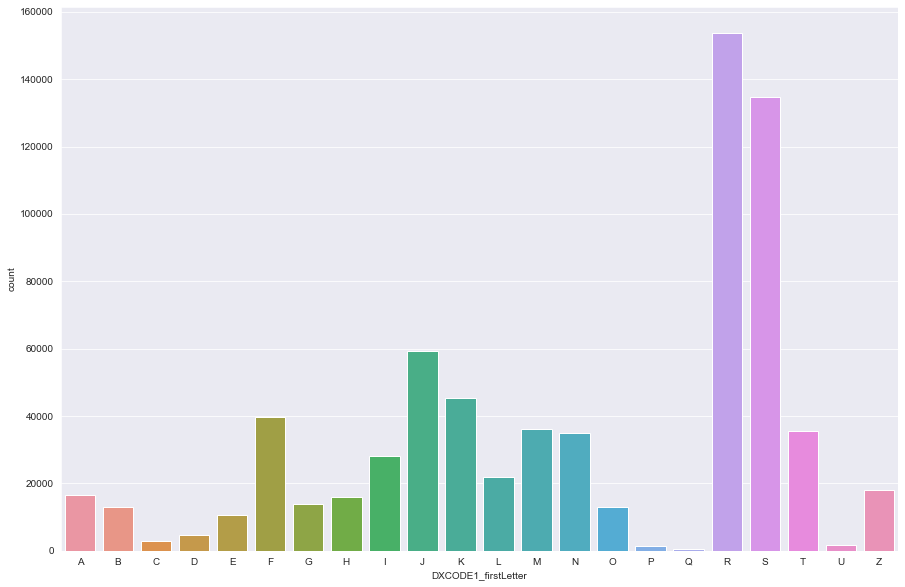

In [3]:
plt.figure(figsize=(15,10))
sns.countplot(x = df_rav['DXCODE1_firstLetter'].sort_values())

When converting from the DX Code to the MDC format, notice that we do not have any V, X nor Y.

#### MDC CODE DESCRIPTION
MDC Code Description:

- 0 Ungroupable
- 1 Nervous System
- 2 Eye
- 3 Ear, Nose, Mouth And Throat
- 4 Respiratory System
- 5 Circulatory System
- 6 Digestive System
- 7 Hepatobiliary System And Pancreas
- 8 Musculoskeletal System And Connective Tissue
- 9 Skin, Subcutaneous Tissue And Breast
- 10 Endocrine, Nutritional And Metabolic System
- 11 Kidney And Urinary Tract
- 12 Male Reproductive System
- 13 Female Reproductive System
- 14 Pregnancy, Childbirth And Puerperium
- 15 Newborn And Other Neonates (Perinatal Period)
- 16 Blood and Blood Forming Organs and Immunological Disorders
- 17 Myeloproliferative DDs (Poorly Differentiated Neoplasms)
- 18 Infectious and Parasitic DDs Services Agencies Search Utah.gov
- 19 Mental Diseases and Disorders
- 20 Alcohol/Drug Use or Induced Mental Disorders
- 21 Injuries, Poison And Toxic Effect of Drugs
- 22 Burns
- 23 Factors Influencing Health Status
- 24 Multiple Significant Trauma
- 25 Human Immunodeficiency Virus Infection

#### Plot for How many in each Diagonsis Code

[Text(0, 0, 'not classified symptoms'),
 Text(1, 0, 'injury'),
 Text(2, 0, 'muscular skeleton'),
 Text(3, 0, 'neoplasm'),
 Text(4, 0, 'mental'),
 Text(5, 0, 'poison'),
 Text(6, 0, 'influence factor'),
 Text(7, 0, 'digestive'),
 Text(8, 0, 'genitourinary'),
 Text(9, 0, 'special purpose'),
 Text(10, 0, 'respiratory'),
 Text(11, 0, 'infectious'),
 Text(12, 0, 'endocrine'),
 Text(13, 0, 'circulatory'),
 Text(14, 0, 'nervous sys'),
 Text(15, 0, 'skin'),
 Text(16, 0, 'ear'),
 Text(17, 0, 'pregnancy'),
 Text(18, 0, 'eye'),
 Text(19, 0, 'congenital'),
 Text(20, 0, 'blood, blood form organs'),
 Text(21, 0, 'perinatal')]

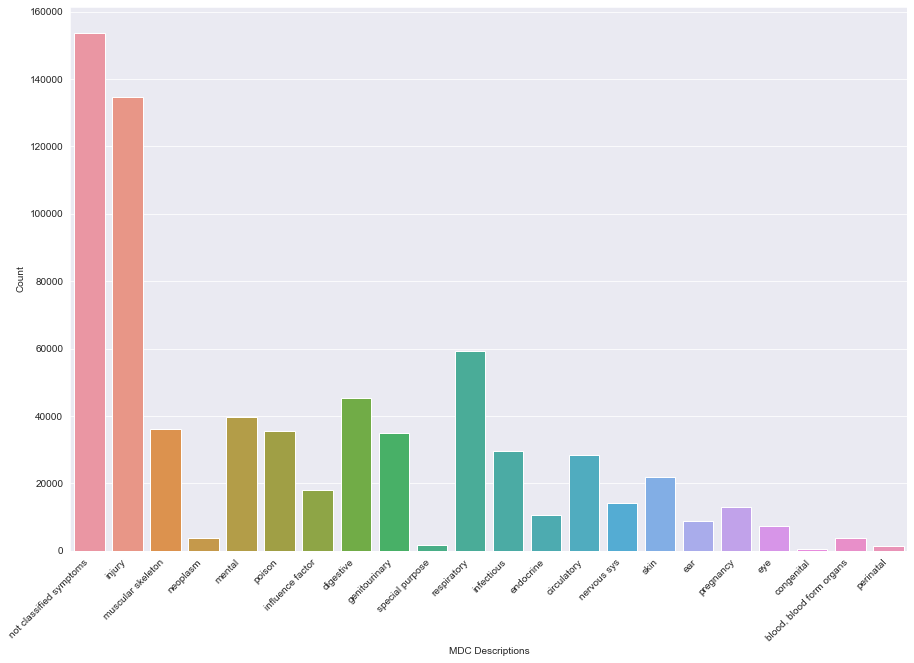

In [4]:
plt.figure(figsize=(15,10))
MDC_descrip_chart = sns.countplot(x = df_rav["MDC_descrip"])
MDC_descrip_chart.set(xlabel = "MDC Descriptions", ylabel="Count")
MDC_descrip_chart.set_xticklabels(MDC_descrip_chart.get_xticklabels(), rotation = 45, horizontalalignment = "right")

# Procedure / Treatment


#### Plot Functions, Table and HeatMap

In [5]:
keepCols = ['PTID', 'DISP_GROUP', 'DXCODE1', 'PROCCODE1', 'MDC', 'MDC_descrip', 'CCI_1_Section','CCI_1_Section_CodeRange', 'age_groups', 'AGE_GROUP', 'DI_toTriage']
treatment_df = df_rav[keepCols]
# Plot
def CCI_1_plot(dataframe, section = None, admitVsDischarge = False):
    if admitVsDischarge:
        if section is not None:
            name = CCI_1_Sections.get(section)
            ylab = f"CCI Section {section} Sub-categories"
            plotTitle = f"CCI Section {section}: {name}"
        else:
            ylab = 'CCI'
            plotTitle = "CCI Sections"
        plt.figure(figsize= (8,8))
        dat = dataframe[(dataframe['DISP_GROUP'] == 'Discharged') | (dataframe['DISP_GROUP'] == 'Admitted')]
        ax = sns.histplot(data = dat, y = 'CCI_1_SubSection', hue = 'DISP_GROUP', multiple= 'stack')
        ax.set(ylabel= ylab, xlabel= "Counts", title = plotTitle)
        # ax.tick_params(axis = 'x', rotation = 90)
        leg = ax.get_legend()
        patientType = leg.legendHandles
        leg.remove()
        ax.legend(patientType, ['Discharged', 'Admitted'], title = 'Patient Status')
        plt.show()

    else:
        if section is not None:
            name = CCI_1_Sections.get(section)
            ylab = f"CCI Section {section} Sub-categories"
            plotTitle = f"CCI Section {section}: {name}"
        else:
            ylab = 'CCI'
            plotTitle = "CCI Sections"

        plt.figure(figsize=(8,8))
        ax = sns.histplot(y = dataframe['CCI_1_SubSection'], stat="density", color ="darkred")

        ax.set(ylabel= ylab, xlabel= "Percentage", title = plotTitle)
        # ax.tick_params(axis = 'x', rotation = 90)

# Table
def CCI_1_table(dataframe, admitVsDischarge = False):
    if admitVsDischarge:
        discharged  = dataframe[dataframe['DISP_GROUP'] == 'Discharged']
        admitted    = dataframe[dataframe['DISP_GROUP'] == 'Admitted']
        dis_per     = pd.DataFrame(round((round(discharged.CCI_1_SubSection.value_counts() / len(discharged.CCI_1_SubSection) , 4) * 100), 2))
        adm_per     = pd.DataFrame(round((round(admitted.CCI_1_SubSection.value_counts() / len(admitted.CCI_1_SubSection) , 4) * 100), 2))
        dat         = pd.concat([dis_per, adm_per], axis = 1)
        dat.columns = ['Discharged %', 'Admitted %']
        return dat
    else:
        dat         = pd.DataFrame(round( (round(dataframe.CCI_1_SubSection.value_counts() / len(dataframe.CCI_1_SubSection), 4)  * 100), 2))
        dat.columns = ['%']
        return dat

# HeatMap
def CCI_1_heatmap(dataframe, section = None, admitVsDischarge = False):
    if admitVsDischarge:
        discharg = dataframe[dataframe['DISP_GROUP'] == 'Discharged']
        admit    = dataframe[dataframe['DISP_GROUP'] == 'Admitted']
        #Discharge Transition Matrix
        dis_group= discharg[['MDC_descrip', 'CCI_1_SubSection', 'PTID']].groupby(['MDC_descrip', 'CCI_1_SubSection'], as_index = False).count()
        tran_dis = dis_group.pivot_table(index = 'MDC_descrip', columns = 'CCI_1_SubSection', values = 'PTID', fill_value = 0)
        tran_dis['sum'] = tran_dis.apply(np.sum, axis = 1)
        colsNums = dis_group.CCI_1_SubSection.nunique()
        for i in range(0, colsNums):
            colname = tran_dis.columns.tolist()[i]
            tran_dis[colname] = round(tran_dis[colname]/tran_dis['sum'],4)*100
        tran_dis = tran_dis.drop(columns = 'sum')

        #Admit Transition Matrix
        adm_group= admit[['MDC_descrip', 'CCI_1_SubSection', 'PTID']].groupby(['MDC_descrip', 'CCI_1_SubSection'], as_index = False).count()
        tran_adm = adm_group.pivot_table(index = 'MDC_descrip', columns = 'CCI_1_SubSection', values = 'PTID', fill_value = 0)
        tran_adm['sum'] = tran_adm.apply(np.sum, axis = 1)
        colsNums = adm_group.CCI_1_SubSection.nunique()
        for i in range(0, colsNums):
            colname = tran_adm.columns.tolist()[i]
            tran_adm[colname] = round(tran_adm[colname]/tran_adm['sum'],4)*100
        tran_adm = tran_adm.drop(columns = 'sum')

        #Heatmap for Discharged vs. Admit
        if section is None:
            xlab = 'CCI'
        else:
            xlab = f"CCI Section {section}"
        fig, (ax,ax2) = plt.subplots(ncols=2, figsize = (20,15))
        fig.subplots_adjust(wspace=0.05)
        ax = sns.heatmap(tran_dis, annot=True, fmt = ".2f", linewidths = .5, ax = ax, cmap = 'Blues')
        ax2 = sns.heatmap(tran_adm, annot=True, fmt = ".2f", linewidths= .5, ax = ax2, cmap = 'BuPu', yticklabels= False)
        ax.set_xlabel(xlab)
        ax.set_ylabel('MDC Descriptions')
        ax.set_title('Discharged')
        ax2.set_xlabel(xlab)
        ax2.yaxis.tick_right()
        ax2.tick_params(rotation=90)
        ax2.set_title('Admitted')
        ax2.set_ylabel('')
        plt.show()

    else:
        #transition matrix
        grouped = dataframe[['MDC_descrip', 'CCI_1_SubSection', 'PTID']].groupby(['MDC_descrip', 'CCI_1_SubSection'], as_index = False).count()
        transition = grouped.pivot_table(index = 'MDC_descrip', columns = 'CCI_1_SubSection', values = 'PTID', fill_value = 0)
        transition['sum'] = transition.apply(np.sum, axis = 1)
        colsNums = grouped.CCI_1_SubSection.nunique()

        for i in range(0, colsNums):
            colname = transition.columns.tolist()[i]
            transition[colname] = round(transition[colname]/transition['sum'],4)*100
        transition = transition.drop(columns = 'sum')

        #Heat Map
        f, ax = plt.subplots(figsize = (10,8))
        heatmap = sns.heatmap(transition, annot=True, fmt = ".2f", linewidths = .5, ax = ax)

        if section is None:
            xlab = 'CCI'
        else:
            xlab = f"CCI Section {section}"

        heatmap.set_xlabel(xlab)
        heatmap.set_ylabel('MDC Descriptions')


## General CCI Sections (Without Sub-categories)

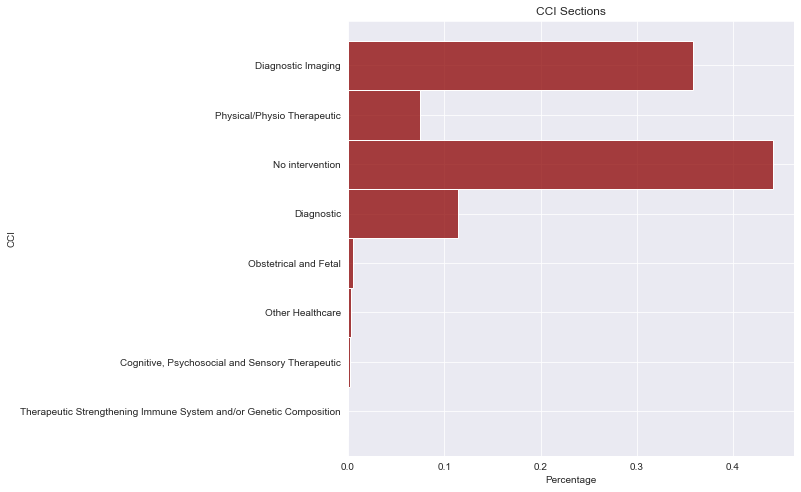

In [6]:
treatment_df_2 = treatment_df.copy()
treatment_df_2['CCI_1_SubSection'] = treatment_df_2['CCI_1_Section']
CCI_1_plot(dataframe= treatment_df_2)

In [7]:
CCI_1_table(dataframe=treatment_df_2)

%
No intervention                                     44.16
Diagnostic Imaging                                  35.83
Diagnostic                                          11.48
Physical/Physio Therapeutic                          7.44
Obstetrical and Fetal                                0.51
Other Healthcare                                     0.37
Cognitive, Psychosocial and Sensory Therapeutic      0.20
Therapeutic Strengthening Immune System and/or ...   0.01

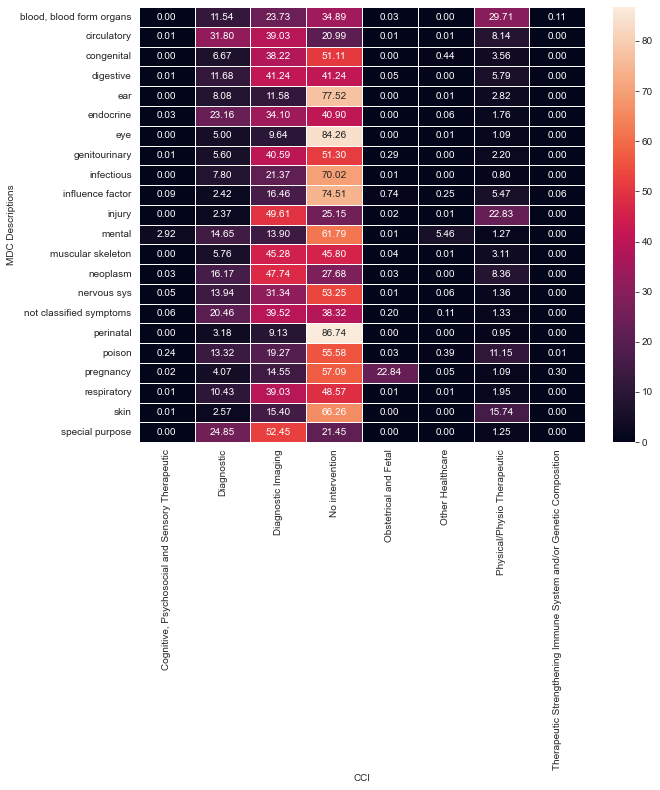

In [8]:
CCI_1_heatmap(dataframe=treatment_df_2)

### Discharged Vs. Admitted for General CCI Sections


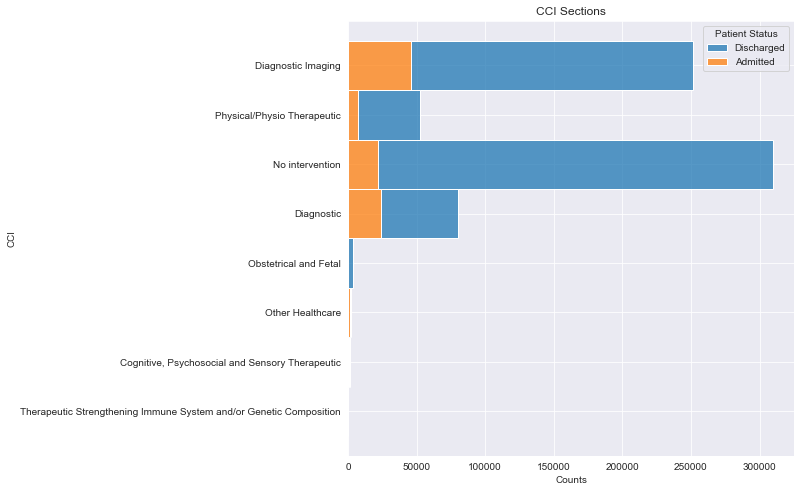

In [9]:
CCI_1_plot(dataframe= treatment_df_2, admitVsDischarge= True)

In [10]:
CCI_1_table(dataframe= treatment_df_2, admitVsDischarge= True)

Discharged %  Admitted %
No intervention                                            47.98       21.42
Diagnostic Imaging                                         34.20       45.51
Diagnostic                                                  9.46       23.51
Physical/Physio Therapeutic                                 7.49        7.18
Obstetrical and Fetal                                       0.55        0.33
Other Healthcare                                            0.20        1.37
Cognitive, Psychosocial and Sensory Therapeutic             0.12        0.67
Therapeutic Strengthening Immune System and/or ...          0.01        0.00

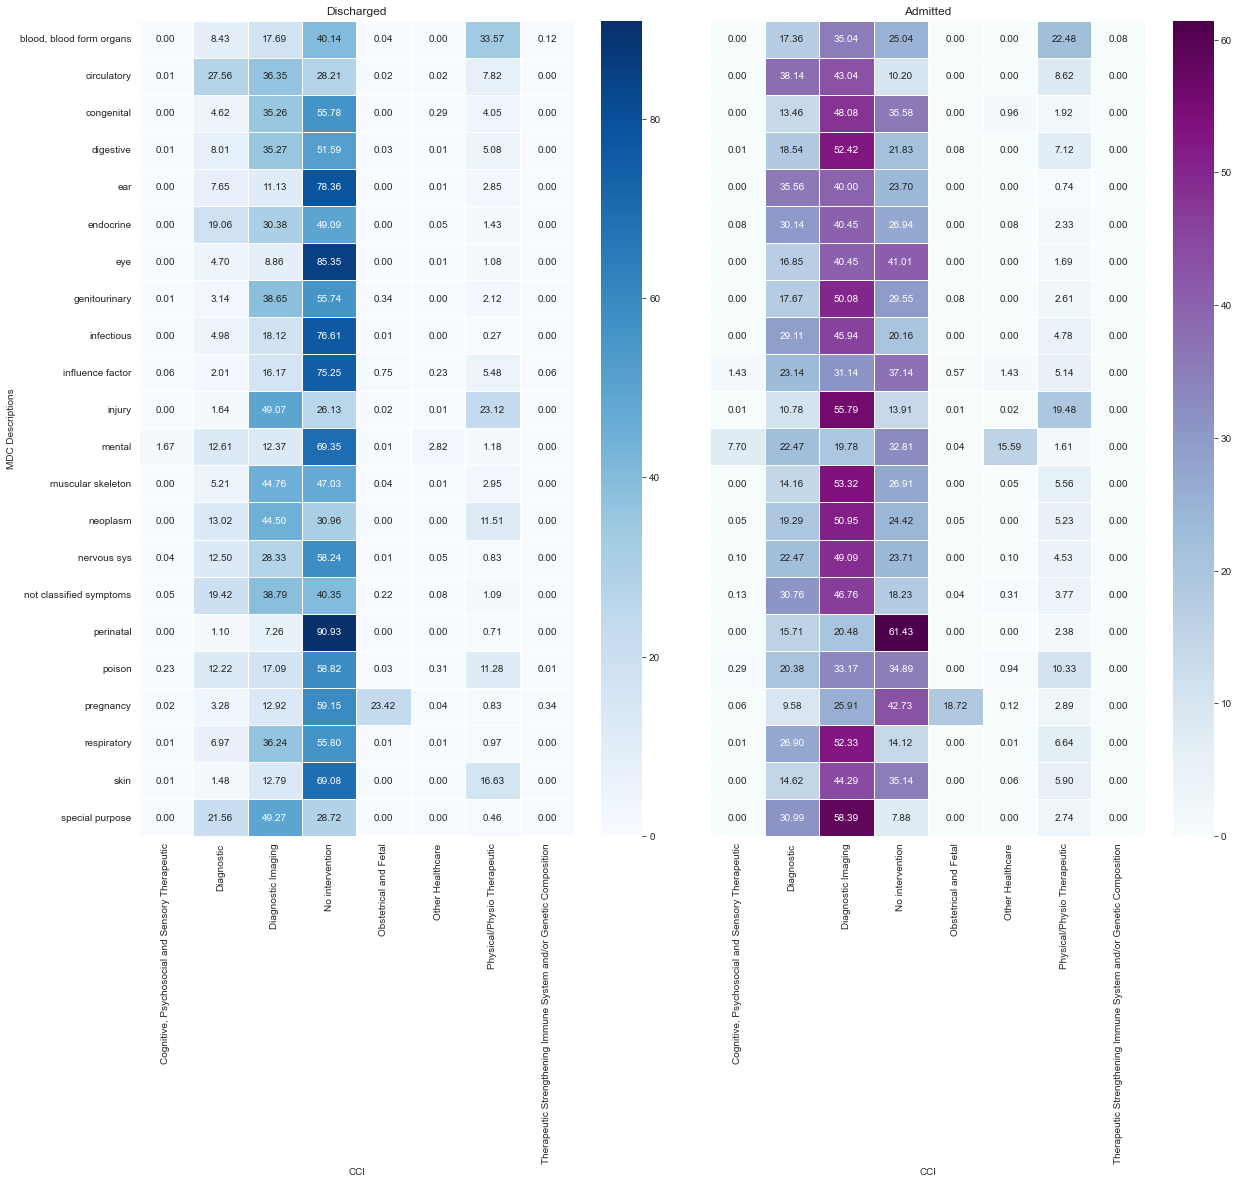

In [11]:
CCI_1_heatmap(dataframe= treatment_df_2, admitVsDischarge= True)

## Section 1: Physical/Physiological Therapeutic Interventions

#### Converting the Code Range to the assigned subcategories of Section 1

In [12]:
def ccisection1(code):
    if (code >= 'AA') & (code <= 'BZ'):
        return "Nervous System"
    elif (code >= 'CC') & (code <= 'CZ'):
        return "Eye and Ocular Adnexa"
    elif (code >= 'DA') & (code <= 'DZ'):
        return "Ear and Mastoid (process)"
    elif (code >= 'EA') & (code <= 'FX'):
        return "Orocraniofacial Region"
    elif (code >= 'GA') & (code <= 'GZ'):
        return "Respiratory System"
    elif (code >= 'HA') & (code <= 'LZ'):
        return "Cardiovascular System"
    elif (code >= 'MA') & (code <= 'MZ'):
        return "Lymphatic System"
    elif (code >= 'NA') & (code <= 'OZ'):
        return "Digestive, Hepatobil. Tracts, Other Sites within Abdom. Cavity NEC"
    elif (code >= 'PB') & (code <= 'RZ'):
        return "Genitourinary System"
    elif (code >= 'SA') & (code <= 'WZ'):
        return "Musculoskeletal System"
    elif (code >= 'YA') & (code <= 'YZ'):
        return "Skin, Subcutaneous Tissue & Breast"
    elif (code >= 'ZX') & (code <= 'ZZ'):
        return "Body NEC"
    else:
        return "Unknown Therapeutic"

CCI_1_Section1 = treatment_df[treatment_df['CCI_1_Section'] == "Physical/Physio Therapeutic"]
CCI_1_Section1['CCI_1_SubSection'] = CCI_1_Section1['CCI_1_Section_CodeRange'].apply(ccisection1)

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/2378721084.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCI_1_Section1['CCI_1_SubSection'] = CCI_1_Section1['CCI_1_Section_CodeRange'].apply(ccisection1)


#### Plot for CCI Section 1 Categories

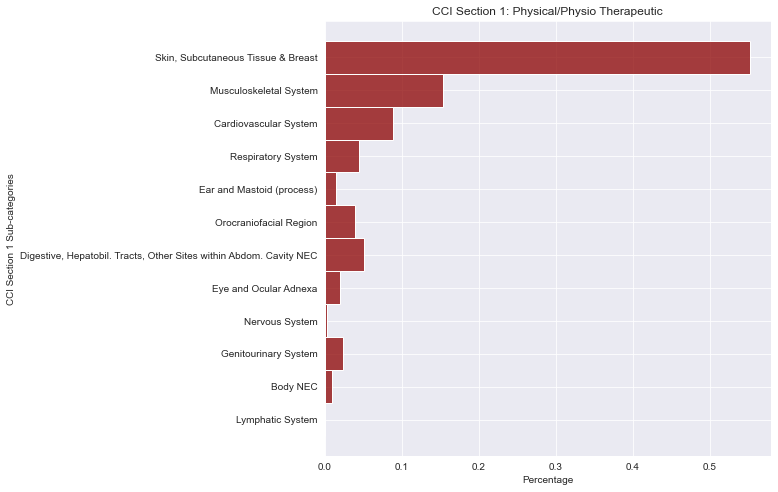

In [13]:
CCI_1_plot(dataframe= CCI_1_Section1, section ='1')

In [14]:
CCI_1_table(dataframe= CCI_1_Section1)

%
Skin, Subcutaneous Tissue & Breast                  55.21
Musculoskeletal System                              15.38
Cardiovascular System                                8.82
Digestive, Hepatobil. Tracts, Other Sites withi...   5.10
Respiratory System                                   4.49
Orocraniofacial Region                               3.94
Genitourinary System                                 2.36
Eye and Ocular Adnexa                                2.06
Ear and Mastoid (process)                            1.43
Body NEC                                             0.94
Nervous System                                       0.26
Lymphatic System                                     0.01

Based on the plot and the above table, it seems clear that most of the data for Section 1 interventions were towards Skin, Subcutaneous Tissue & Breast. It would make sense to separate this out from the rest of Section 1. Hence, we will have 2 components for section 1.

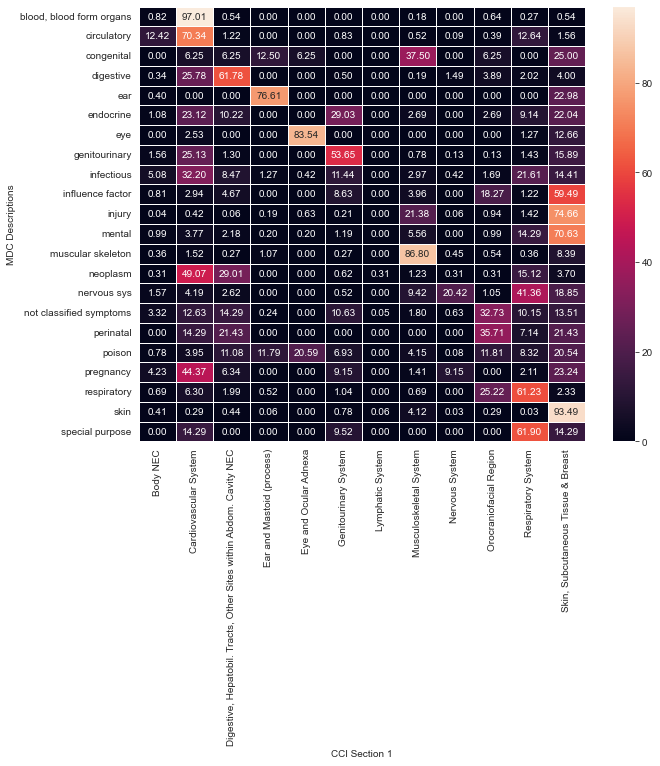

In [15]:
CCI_1_heatmap(dataframe= CCI_1_Section1, section ='1')

### Discharged vs. Admitted for Section 1


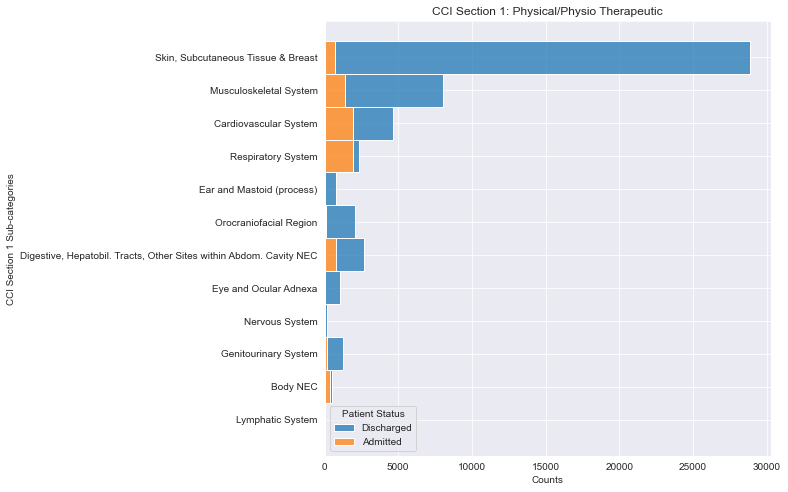

In [16]:
CCI_1_plot(dataframe= CCI_1_Section1, section= '1', admitVsDischarge= True)

In [17]:
CCI_1_table(dataframe= CCI_1_Section1, admitVsDischarge= True)

Discharged %  Admitted %
Skin, Subcutaneous Tissue & Breast                         62.61        9.37
Musculoskeletal System                                     14.85       18.69
Cardiovascular System                                       6.01       26.23
Orocraniofacial Region                                      4.43        0.87
Digestive, Hepatobil. Tracts, Other Sites withi...          4.17       10.86
Eye and Ocular Adnexa                                       2.38        0.08
Genitourinary System                                        2.33        2.54
Ear and Mastoid (process)                                   1.65        0.04
Respiratory System                                          0.95       26.41
Body NEC                                                    0.33        4.74
Nervous System                                              0.28        0.18
Lymphatic System                                            0.01         NaN

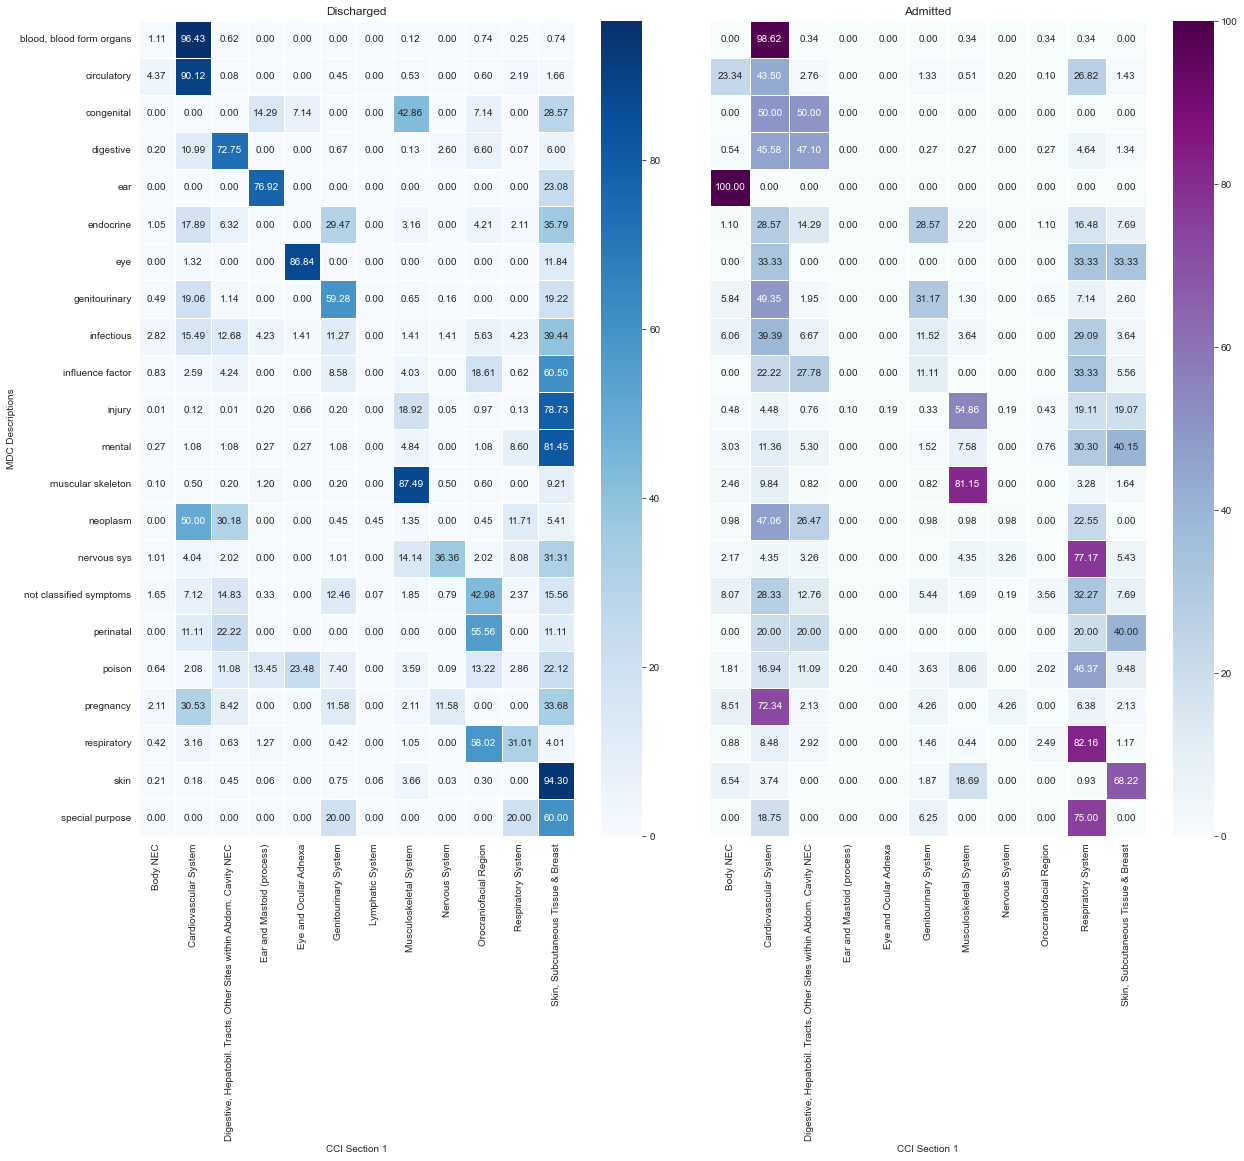

In [18]:
CCI_1_heatmap(dataframe= CCI_1_Section1, section= '1', admitVsDischarge= True)

### Looking at Top 2 Therapeutic Interventions

Musculoskeletal System (SA - WZ)
Skin, Subcutaneous Tissue and Breast (YA - YZ)


In [19]:
CCI_1_Section1_top2 = CCI_1_Section1[
    (CCI_1_Section1['CCI_1_SubSection'] == "Skin, Subcutaneous Tissue & Breast")
    |
    (CCI_1_Section1['CCI_1_SubSection'] == "Musculoskeletal System")
    ]

In [20]:
CCI_1_Section1_top2['CCI_1_Section_CodeRange'] = CCI_1_Section1_top2.PROCCODE1.astype(str).str[1:5]
grouped_df = CCI_1_Section1_top2.groupby('CCI_1_Section_CodeRange')['PTID'].count().reset_index()
grouped_df[grouped_df['PTID'] > 0.02*grouped_df.PTID.sum()]

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/2777151928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCI_1_Section1_top2['CCI_1_Section_CodeRange'] = CCI_1_Section1_top2.PROCCODE1.astype(str).str[1:5]


CCI_1_Section_CodeRange  PTID
21                     TA73  1101
34                     TM73   910
41                     TV73  1170
53                     UB73   875
165                    YA80  2677
171                    YB80  3179
187                    YE80  1071
196                    YF80  2818
214                    YS52  1346
227                    YT80  1571
234                    YU80  7494
243                    YV80  1628
250                    YW80   765

In [21]:
def ccisection1top2(code):
    top4Code = code[1:3]
    intervention = code[3:5]
    if (top4Code >= 'SA') & (top4Code <= 'WZ'):
        if (top4Code == 'TA') & (intervention == '73'):
            return "Reduction, shoulder joint"
        elif (top4Code == 'TM') & (intervention == '73'):
            return "Reduction, elbow joint"
        elif (top4Code == 'TV') & (intervention == '73'):
            return "Reduction, radius and ulna"
        elif (top4Code == 'UB') & (intervention == '73'):
            return "Reduction, wrist joint"
        else:
            return "Other Musculoskeletal Therapeutic"
    elif (top4Code >= 'YA') & (top4Code <= 'YZ'):
        if (top4Code == 'YA') & (intervention == '80'):
            return "Repair, scalp"
        elif (top4Code == 'YB') & (intervention == '80') :
                return "Repair, skin of forehead"
        elif (top4Code == 'YE') & (intervention == '80'):
            return "Repair, lip"
        elif (top4Code == 'YF') & (intervention == '80'):
            return "Repair, skin of face"
        elif (top4Code == 'YS') & (intervention == '52'):
            return "Drainage, skin of abdomen and trunk"
        elif (top4Code == 'YT') & (intervention == '80'):
            return "Repair, skin of arm"
        elif (top4Code == 'YU') & (intervention == '80'):
            return "Repair, skin of hand"
        elif (top4Code == 'YV') & (intervention == '80'):
            return "Repair, skin of leg"
        elif (top4Code == 'YW') & (intervention == '80'):
            return "Repair, skin of foot"
        else:
            return "Other Skin, Subcutaneous Tissue & Breast Therapeutic"
    else:
        return "Other Therapeutic Intervention"

CCI_1_Section1['CCI_1_SubSection'] = CCI_1_Section1['PROCCODE1'].apply(ccisection1top2)

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/1674720108.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCI_1_Section1['CCI_1_SubSection'] = CCI_1_Section1['PROCCODE1'].apply(ccisection1top2)


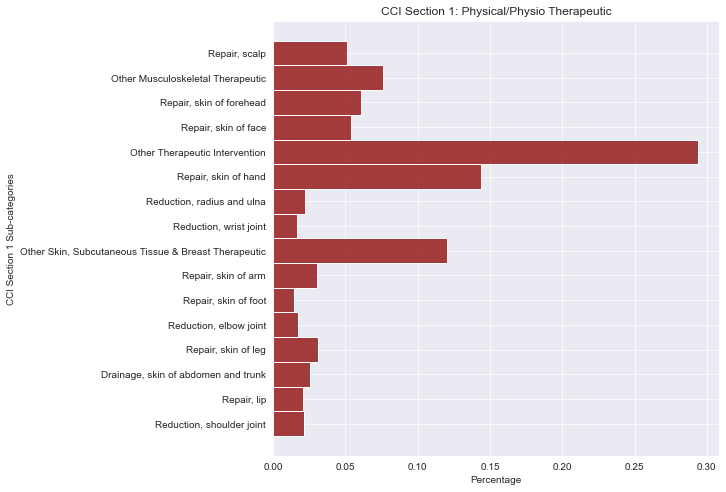

In [22]:
CCI_1_plot(dataframe= CCI_1_Section1, section= '1')

In [23]:
CCI_1_table(dataframe= CCI_1_Section1)

%
Other Therapeutic Intervention                      29.41
Repair, skin of hand                                14.35
Other Skin, Subcutaneous Tissue & Breast Therap...  12.03
Other Musculoskeletal Therapeutic                    7.61
Repair, skin of forehead                             6.09
Repair, skin of face                                 5.40
Repair, scalp                                        5.13
Repair, skin of leg                                  3.12
Repair, skin of arm                                  3.01
Drainage, skin of abdomen and trunk                  2.58
Reduction, radius and ulna                           2.24
Reduction, shoulder joint                            2.11
Repair, lip                                          2.05
Reduction, elbow joint                               1.74
Reduction, wrist joint                               1.68
Repair, skin of foot                                 1.46

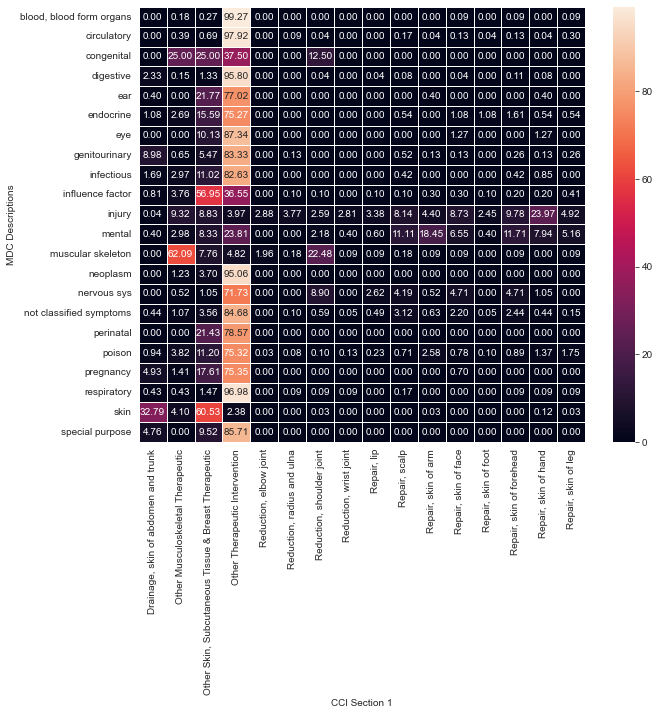

In [24]:
CCI_1_heatmap(dataframe=CCI_1_Section1, section= '1')

Based on the following output above, we can group Section 1 in the following way:
- Thera. Skin Subcutaneous Tissue & Breast
- Repair Skin on Hand
- Thera. Musculoskeletal
- General Thera. Intervention

Below is the function to identify the particular subgroups of Section 1 codes:

In [25]:
def CCI_section1(code):
    sectionCode = code[1:3]
    intervention = code[3:5]
    if (sectionCode >= 'SA') & (sectionCode <= 'WZ'):
        return "Therapeutic Musculoskeletal"
    elif (sectionCode >= 'YA') & (sectionCode <= 'YZ'):
        if (sectionCode == 'YU') & (intervention == '80'):
            return "Repair, skin of hand"
        else:
            return "Therapeutic Skin Subcut. Tissue & Breast"
    else:
        return "Gen. Therapeutic. Intervention"

## Section 2: Diagnostic Interventions

#### Converting the Code Range to the assigned subcategories of Section 2

In [26]:
def ccisection2(code):
    if (code >= 'AA') & (code <= 'BX'):
        return "Nervous System"
    elif (code >= 'CC') & (code <= 'CZ'):
        return "Eye and Ocular Adnexa"
    elif (code >= 'DA') & (code <= 'DZ'):
        return "Ear and Mastoid (process)"
    elif (code >= 'EA') & (code <= 'FY'):
        return "Orocraniofacial Region"
    elif (code >= 'GE') & (code <= 'GZ'):
        return "Respiratory System"
    elif (code >= 'HA') & (code <= 'LZ'):
        return "Cardiovascular System"
    elif (code >= 'MA') & (code <= 'MZ'):
        return "Lymphatic System"
    elif (code >= 'NA') & (code <= 'OZ'):
        return "Digestive, Hepatobil. Tracts, Other Sites within Abdom. Cavity NEC"
    elif (code >= 'PB') & (code <= 'RZ'):
        return "Genitourinary System"
    elif (code >= 'SA') & (code <= 'WZ'):
        return "Musculoskeletal System"
    elif (code >= 'YA') & (code <= 'YZ'):
        return "Skin, Subcutaneous Tissue & Breast"
    elif code == 'ZZ':
        return "Body System NEC"
    else:
        return "Unknown Diagnostic"

CCI_1_Section2 = treatment_df[treatment_df['CCI_1_Section'] == "Diagnostic"]
CCI_1_Section2['CCI_1_SubSection'] = CCI_1_Section2['CCI_1_Section_CodeRange'].apply(ccisection2)

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/2790193371.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCI_1_Section2['CCI_1_SubSection'] = CCI_1_Section2['CCI_1_Section_CodeRange'].apply(ccisection2)


#### Plot for CCI Section 2 Categories

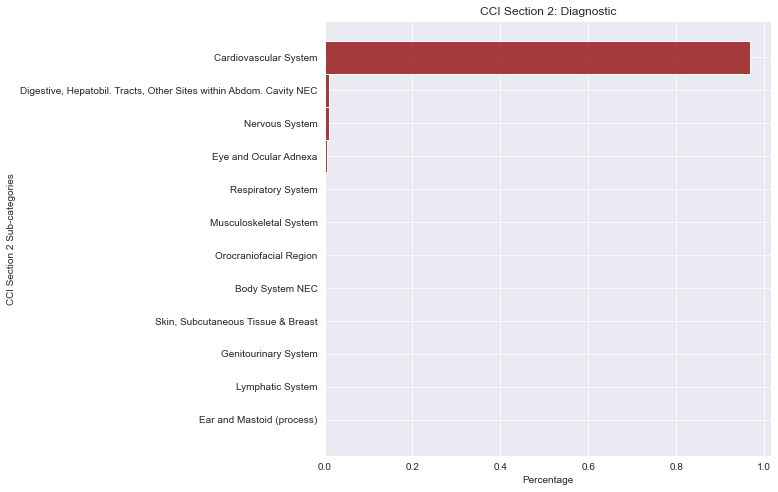

In [27]:
CCI_1_plot(dataframe= CCI_1_Section2, section='2')

In [28]:
CCI_1_table(dataframe= CCI_1_Section2)

%
Cardiovascular System                               96.72
Nervous System                                       1.01
Digestive, Hepatobil. Tracts, Other Sites withi...   0.98
Eye and Ocular Adnexa                                0.64
Musculoskeletal System                               0.16
Body System NEC                                      0.14
Orocraniofacial Region                               0.12
Respiratory System                                   0.11
Genitourinary System                                 0.07
Skin, Subcutaneous Tissue & Breast                   0.04
Ear and Mastoid (process)                            0.00
Lymphatic System                                     0.00

Based on the plot and the above table, it seems clear that most of the data for Section 2 interventions were towards Cardiovascular System. It would make sense to separate this out from the rest of Section 2. Hence, we will have 2 components for section 2.

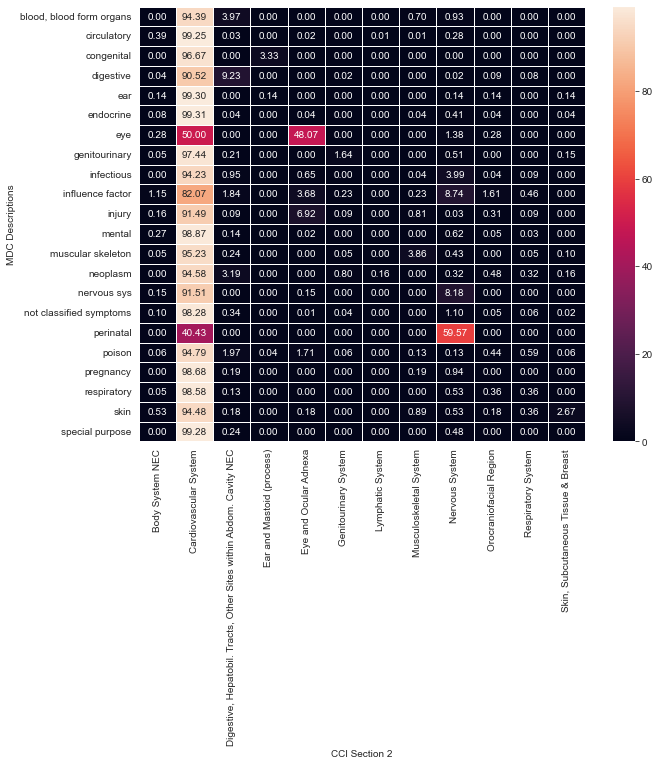

In [29]:
CCI_1_heatmap(dataframe= CCI_1_Section2, section ='2')

### Discharged vs. Admitted for Section 2

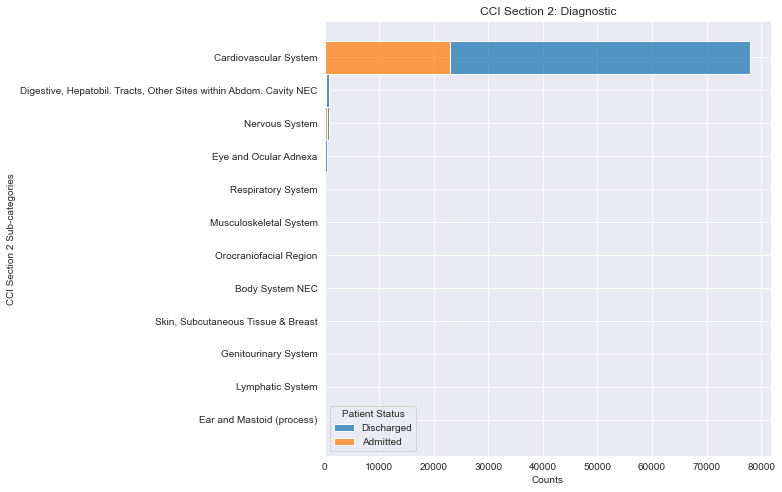

In [30]:
CCI_1_plot(dataframe= CCI_1_Section2, section='2', admitVsDischarge= True)

In [31]:
CCI_1_table(dataframe= CCI_1_Section2, admitVsDischarge= True)

Discharged %  Admitted %
Cardiovascular System                                      96.59       97.05
Digestive, Hepatobil. Tracts, Other Sites withi...          1.05        0.82
Eye and Ocular Adnexa                                       0.91        0.02
Nervous System                                              0.74        1.67
Musculoskeletal System                                      0.20        0.05
Orocraniofacial Region                                      0.14        0.07
Body System NEC                                             0.13        0.16
Respiratory System                                          0.12        0.08
Genitourinary System                                        0.08        0.06
Skin, Subcutaneous Tissue & Breast                          0.05        0.02
Ear and Mastoid (process)                                   0.01         NaN
Lymphatic System                                            0.01         NaN

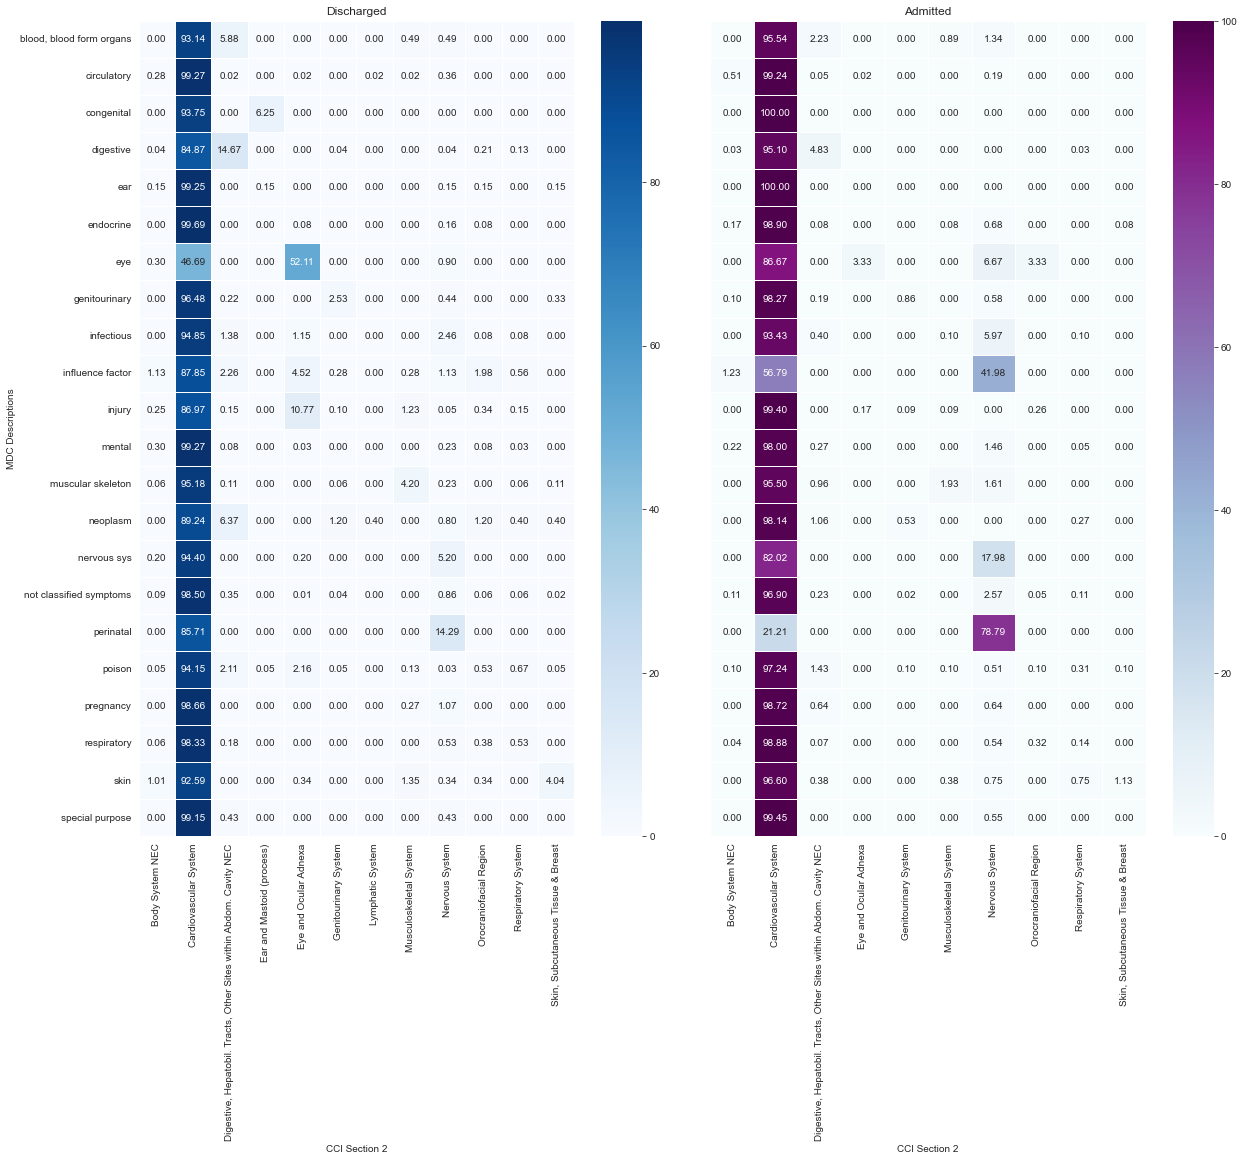

In [32]:
CCI_1_heatmap(dataframe = CCI_1_Section2, section = '2', admitVsDischarge= True)

### Looking at the specific Cardiovascular Sections

HZ Includes:
- General
    - Combined right and left heart
    - Heart NOS
    - Heart tissue NEC
- HZ.24 (Electrophysiological measurement, heart NEC)
    - Includes:
        - Catherization, cardiac, for electrocardiography
        - Electrocardiography (ECG)
        - Insertion, cardiac subcutaneous event recorder
        - Insertion, recording electrodes, heart (intra atrial, intra ventricular)
        - Mapping, cardiac
    - Excludes:
        - that done with insertion of pacemaker
        - that done with phonocardiogram
                -
    - using rhythm strips (rhythm electrocardiogram)
        -  Excludes:
            - that done as part of sleep studies
            - that done for cardiac stress test

JZ includes:
- Carotid bifurcation
- Common carotid arteries
- External carotid arteries
- Internal carotid arteries

LZ includes:
   - Blood
   - LZ.28 (Pressure measurement, circulatory system NEC)
        - Includes:
            - Monitoring, blood pressure (peripheral, cuff)
            - Monitoring, blood pressure, centeral venous
            - Monitoring, blood pressure, systemic arterial
            - Monitoring, pulse rate
        - Excludes:
            - Flow study (occlusion tolerance), carotid artery

In [33]:
CCI_1_Section2_cardio = CCI_1_Section2[CCI_1_Section2['CCI_1_SubSection'] == 'Cardiovascular System']

def ccisection2Cardiovascular(code):
    cardioCode = code[1:3]
    intervention = code[3:5]
    external   = code[5:9]
    if cardioCode == 'HZ':
        if intervention == '07':
            return "Analysis/Evaluation, heart NEC"
        elif intervention == '08':
            return "Test, heart NEC"
        elif intervention == '24':
            if external == 'JAKF':
                return "Using apex Cardiogram"
            elif external == 'JAKH':
                return "using holter monitor"
            elif external == 'JAXJ':
                return "using recording electrodes"
            elif external == 'JAKE':
                return "using rhythm strips (rhythm electrocardiogram)"
            elif external == 'JAKP':
                return "using tilt table test with pharmacol. agent"
            elif external == "JAKT":
                return "using title table"
            elif external == "JAKG":
                return "using vector loops (vector cardiogram)"
            else:
                return "Electrophysiological measurement, heart NEC"
        elif intervention == '29':
            return "Other measurement NEC, heart NEC"
        else:
            return "Cardiovascular System"
    elif cardioCode == 'JX':
        if intervention == '71':
            return "Biopsy, other vessels of head, neck and spine NEC"
        else:
            return "Cardiovascular System"
    elif cardioCode == 'LZ':
        if intervention == '28':
            return "Pressure measurement, circulatory system NEC"
    else:
        return "Cardiovascular System"

CCI_1_Section2_cardio['CCI_1_SubSection'] = CCI_1_Section2_cardio['PROCCODE1'].apply(ccisection2Cardiovascular)

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/2297435028.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCI_1_Section2_cardio['CCI_1_SubSection'] = CCI_1_Section2_cardio['PROCCODE1'].apply(ccisection2Cardiovascular)


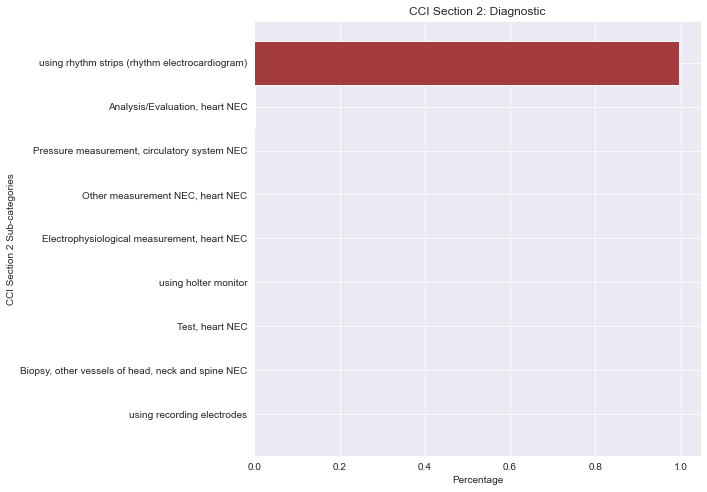

In [34]:
CCI_1_plot(dataframe= CCI_1_Section2_cardio, section= '2')

In [35]:
CCI_1_table(dataframe = CCI_1_Section2_cardio)

%
using rhythm strips (rhythm electrocardiogram)     99.75
Analysis/Evaluation, heart NEC                      0.16
using holter monitor                                0.04
Test, heart NEC                                     0.02
Pressure measurement, circulatory system NEC        0.01
Other measurement NEC, heart NEC                    0.01
Electrophysiological measurement, heart NEC         0.01
Biopsy, other vessels of head, neck and spine NEC   0.00
using recording electrodes                          0.00

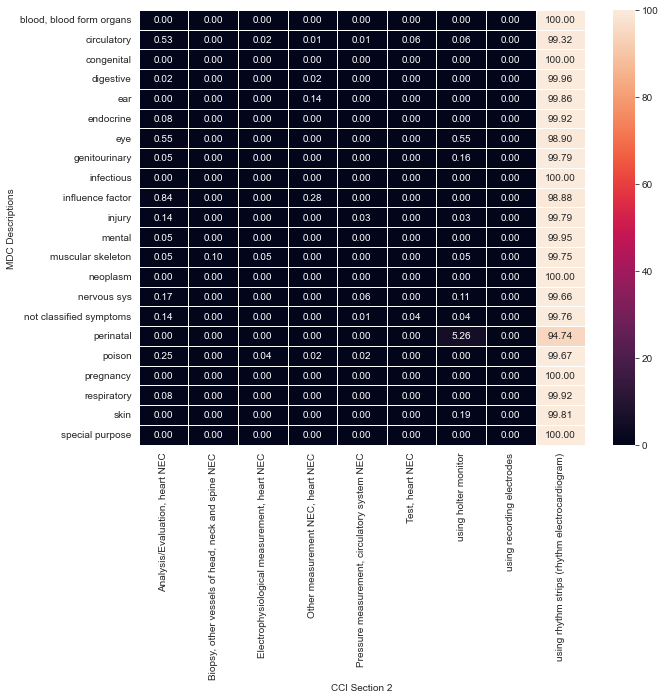

In [36]:
CCI_1_heatmap(dataframe=CCI_1_Section2_cardio, section= '2')

As we can see that the overwhelming majority of Section 2 code is in the "using rhythm strips (rhythm electrocardiogram)". It makes sense to separate this from the rest of the general Section 2.

We can group Section 2 in the following way:
- Diag. rhythm strips (rhythm ECG)
- General Diag. Intervention

Below is the function to identify the particular subgroups of Section 2 codes:

In [37]:
def CCI_Section2(code):
    sectionCode = code[1:3]
    intervention = code[3:5]
    external   = code[5:9]
    if (sectionCode == 'HZ') & (intervention == '24') & (external == 'JAKE'):
        return "Diagnostic. rhythm strip (rhythm ECG"
    else:
        return "Gen. Diagnostic Intervention"

## Section 3: Diagnostic Imaging Interventions

#### Converting the Code Range to the assigned subcategories of Section 3

In [38]:
def ccisection3(code):
    if (code <= 'AF') & (code <= 'AW'):
        return "Nervous System"
    elif (code >= 'CA') & (code <= 'CZ'):
        return "Eye and Ocular Adnexa"
    elif (code >= 'DL') & (code <= 'DZ'):
        return "Ear and Mastoid (process)"
    elif (code >= 'EA') & (code <= 'FY'):
        return "Orocraniofacial Region"
    elif (code >= 'GE') & (code <= 'GY'):
        return "Respiratory System"
    elif (code >= 'HA') & (code <= 'LZ'):
        return "Cardiovascular System"
    elif (code >= 'ML') & (code <= 'MZ'):
        return "Lymphatic System"
    elif (code >= 'NA') & (code <= 'OZ'):
        return "Digestive, Hepatobil. Tracts, Other Sites within Abdom. Cavity NEC"
    elif (code >= 'PB') & (code <= 'RZ'):
        return "Genitourinary System"
    elif (code >= 'SC') & (code <= 'WZ'):
        return "Musculoskeletal System"
    elif (code >= 'YL') & (code <= 'YZ'):
        return "Skin, Subcutaneous Tissue & Breast"
    elif (code >= 'ZA') & (code <= 'ZZ'):
        return "Body System NEC"
    else:
        return "Unknown Diagnostic Imaging"

CCI_1_Section3 = treatment_df[treatment_df['CCI_1_Section'] == "Diagnostic Imaging"]
CCI_1_Section3['CCI_1_SubSection'] = CCI_1_Section3['CCI_1_Section_CodeRange'].apply(ccisection3)

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3896520706.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCI_1_Section3['CCI_1_SubSection'] = CCI_1_Section3['CCI_1_Section_CodeRange'].apply(ccisection3)


#### Plot for CCI Section 3 Categories

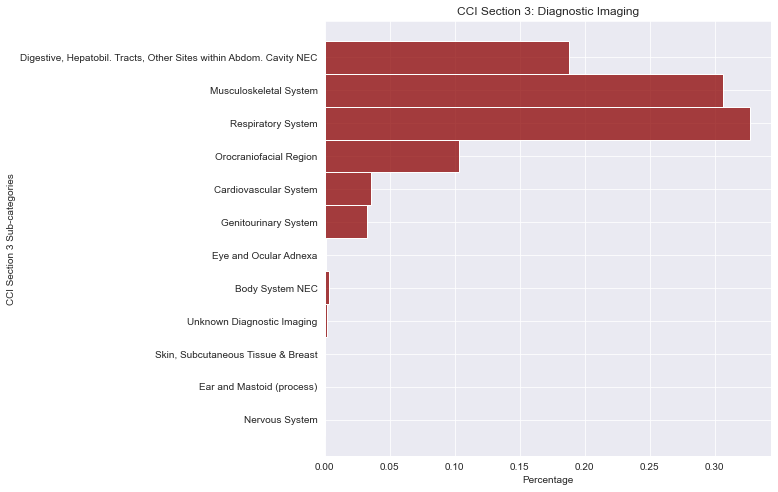

In [39]:
CCI_1_plot(dataframe= CCI_1_Section3, section='3')

In [40]:
CCI_1_table(dataframe= CCI_1_Section3)

%
Respiratory System                                  32.69
Musculoskeletal System                              30.65
Digestive, Hepatobil. Tracts, Other Sites withi...  18.78
Orocraniofacial Region                              10.36
Cardiovascular System                                3.55
Genitourinary System                                 3.25
Body System NEC                                      0.33
Unknown Diagnostic Imaging                           0.18
Eye and Ocular Adnexa                                0.15
Skin, Subcutaneous Tissue & Breast                   0.06
Ear and Mastoid (process)                            0.00
Nervous System                                       0.00

Based on the plot and the above table, it seems clear that most of the data for Section 3 interventions were towards multiple specific interventions. It would make sense to separate this out from the rest of Section 3. Hence, we will have 5 components for section 3.

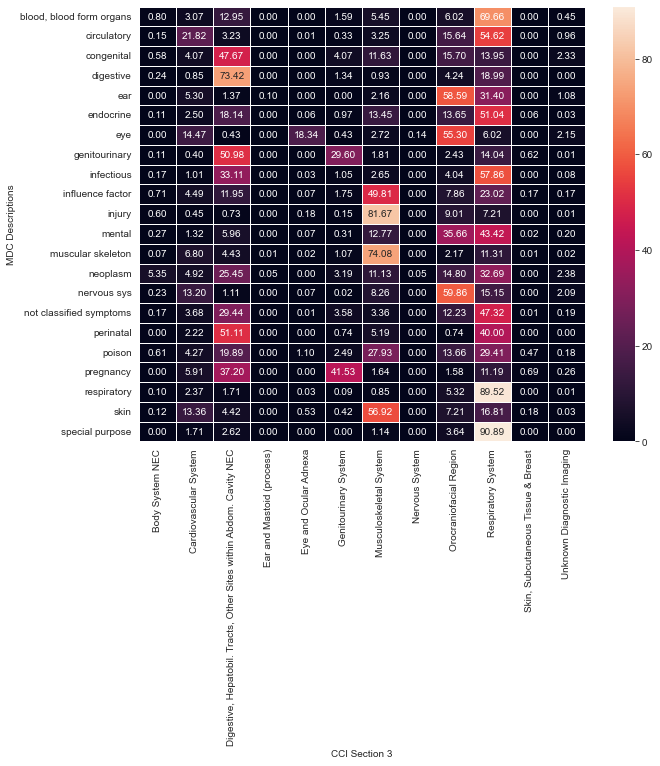

In [41]:
CCI_1_heatmap(dataframe= CCI_1_Section3, section='3')

### Discharged vs. Admitted for Section 3

Excludes:
- actual diagnostic or therapeutic interventions where image assistance is used (these should be coded separately)
- examinations which are unique to the state of pregnancy (.g. obstetrical ultrasound) or the fetus (e.g. Doppler of fetal heart)
- interventions which are therapeutic in nature (e.g. radio-iodine therapy, angioplasty)


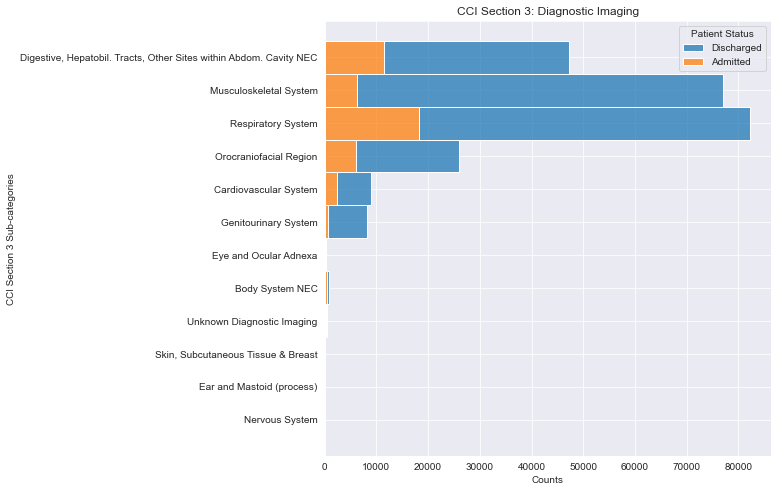

In [42]:
CCI_1_plot(dataframe = CCI_1_Section3, section= '3', admitVsDischarge = True)

In [43]:
CCI_1_table(dataframe = CCI_1_Section3, admitVsDischarge = True)

Discharged %  Admitted %
Musculoskeletal System                                     34.50       13.46
Respiratory System                                         31.09       39.83
Digestive, Hepatobil. Tracts, Other Sites withi...         17.37       25.09
Orocraniofacial Region                                      9.69       13.34
Genitourinary System                                        3.62        1.61
Cardiovascular System                                       3.19        5.13
Body System NEC                                             0.22        0.84
Eye and Ocular Adnexa                                       0.16        0.09
Unknown Diagnostic Imaging                                  0.09        0.56
Skin, Subcutaneous Tissue & Breast                          0.07        0.04
Ear and Mastoid (process)                                   0.00         NaN
Nervous System                                               NaN        0.00

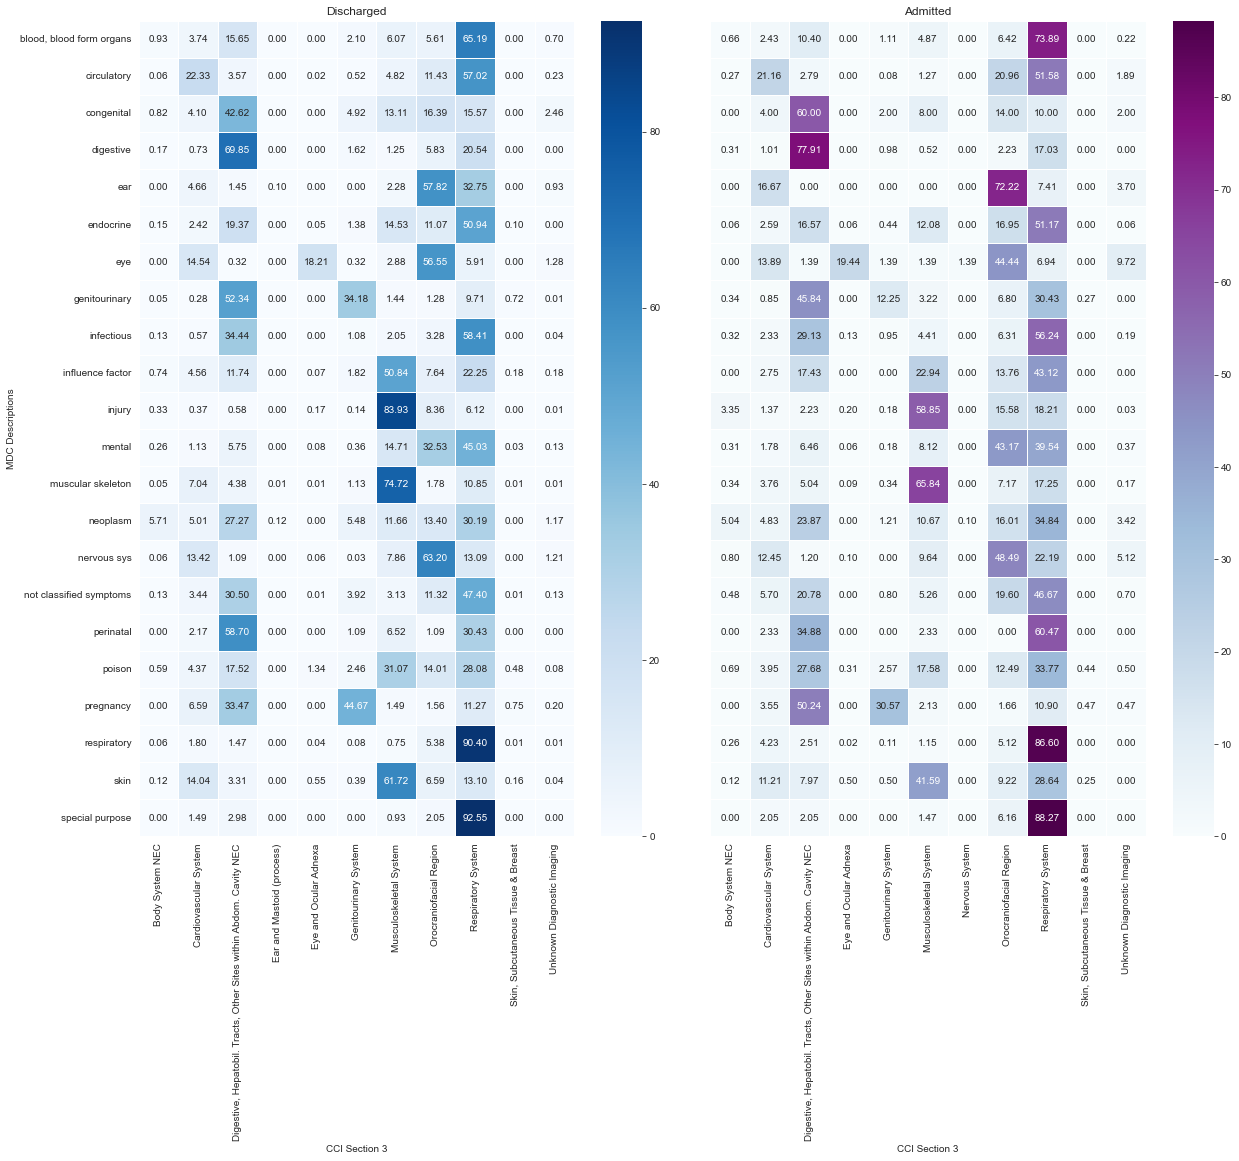

In [44]:
CCI_1_heatmap(dataframe = CCI_1_Section3, section = '3', admitVsDischarge = True)

### Looking at the Top 4 Diagnostic Imaging Interventions: Respiratory, Musculoskel., Digestive, Orocraniofacial

Respiratory System (GE - GY)
Musculoskelatal (SC - WZ)
Digestive, Hepatobil. Tracts, Other Sites within Abdom. Cavity NEC (NA - OZ)
Orocraniofacial (EA - FY)

In [45]:
CCI_1_Section3_top4 = CCI_1_Section3[
    (CCI_1_Section3['CCI_1_SubSection'] == 'Orocraniofacial Region')
    |
    (CCI_1_Section3['CCI_1_SubSection'] == 'Respiratory System')
    |
    (CCI_1_Section3['CCI_1_SubSection'] == 'Digestive, Hepatobil. Tracts, Other Sites within Abdom. Cavity NEC')
    |
    (CCI_1_Section3['CCI_1_SubSection'] == 'Musculoskeletal System')
    ]

In [46]:
CCI_1_Section3_top4['CCI_1_Section_CodeRange'] = CCI_1_Section3_top4.PROCCODE1.astype(str).str[1:5]
grouped_df = CCI_1_Section3_top4.groupby('CCI_1_Section_CodeRange')['PTID'].count().reset_index()
grouped_df[grouped_df['PTID'] > 0.02*grouped_df.PTID.sum()]

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3230640734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCI_1_Section3_top4['CCI_1_Section_CodeRange'] = CCI_1_Section3_top4.PROCCODE1.astype(str).str[1:5]


CCI_1_Section_CodeRange   PTID
8                     ER20  21193
24                    GY10  81360
39                    OT10  13996
42                    OT20  17521
43                    OT30  15436
45                    SC10   7644
67                    UB10   6250
69                    UZ10   5864
73                    VG10   7554
80                    WA10   9096
81                    WG10  10127

Above code, I grouped based on the various subsections of the CCI code. From there I decided to take the subcategories that have more than 2% of data and then grouped the rest.

In [47]:
def ccisection3top4(code):
    top4Code = code[1:3]
    intervention = code[3:5]
    if (top4Code >= 'EA') & (top4Code <= 'FY'):
        if top4Code == 'ER':
            if intervention == '20':
                return "Ultrasound, head NEC"
            else:
                return "Other orocraniofacial region"
        else:
            return "Other orocraniofacial region"
    elif (top4Code >= 'GE') & (top4Code <= 'GY'):
        if top4Code == 'GY':
            if intervention == '10':
                return "Xray, thoracic cavity NEC"
            else:
                return "Other respiratory system"
        else:
            return "Other respiratory system"
    elif (top4Code >= 'NA') & (top4Code <= 'OZ'):
        if top4Code == 'OT':
            if intervention == '10':
                return "Xray, abdominal cavity"
            elif intervention == '20':
                return "Computerized tomography[CT], abdominal cavity"
            elif intervention == '30':
                return "Ultrasound, abdominal cavity"
            else:
                return "Other digestive & hepatobiliary tracts & other sites within abdominal cavity NEC"
        else:
            return "Other digestive & hepatobiliary tracts & other sites within abdominal cavity NEC"
    elif (top4Code >= 'SC') & (top4Code <= 'WZ'):
        if top4Code == 'SC':
            if intervention == '10':
                return "Xray, spinal vertebrae"
            else:
                return "Other musculoskeletal system"
        elif top4Code == 'UB':
            if intervention == '10':
                return "Xray, wrist joint"
            else:
                return "Other musculoskeletal system"
        elif top4Code == 'UZ':
            if intervention == '10':
                return "Xray, hand with wrist"
            else:
                return "Other musculoskeletal system"
        elif top4Code == 'VG':
            if intervention == '10':
                return "Xray, knee joint"
            else:
                return "Other musculoskeletal system"
        elif top4Code == 'WA':
            if intervention == '10':
                return "Xray, ankle joint"
            else:
                return "Other musculoskeletal system"
        elif top4Code == 'WG':
            if intervention == '10':
                return "DI on the foot"
            else:
                return "Other musculoskeletal system"
        else:
            return "Other musculoskeletal system"
    else:
        return "Other DI"

CCI_1_Section3['CCI_1_SubSection'] = CCI_1_Section3['PROCCODE1'].apply(ccisection3top4)

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/1648499823.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCI_1_Section3['CCI_1_SubSection'] = CCI_1_Section3['PROCCODE1'].apply(ccisection3top4)


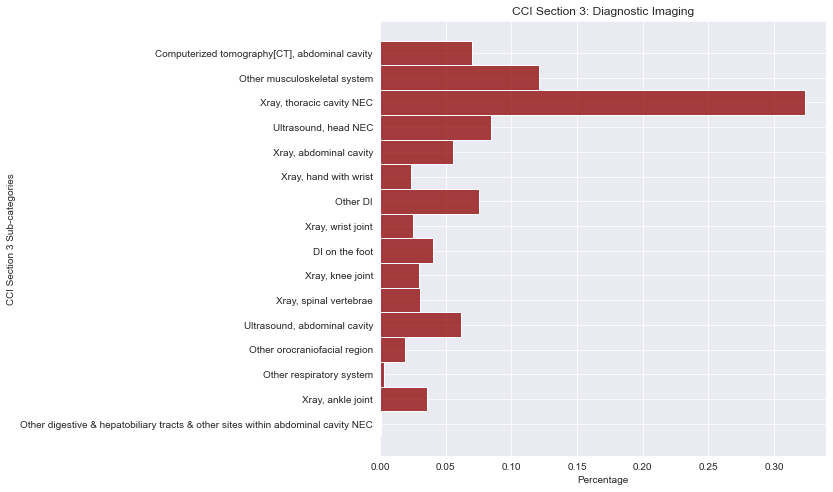

In [48]:
CCI_1_plot(dataframe= CCI_1_Section3, section= '3')

In [49]:
CCI_1_table(dataframe= CCI_1_Section3_top4)

%
Respiratory System                                  35.34
Musculoskeletal System                              33.14
Digestive, Hepatobil. Tracts, Other Sites withi...  20.31
Orocraniofacial Region                              11.20

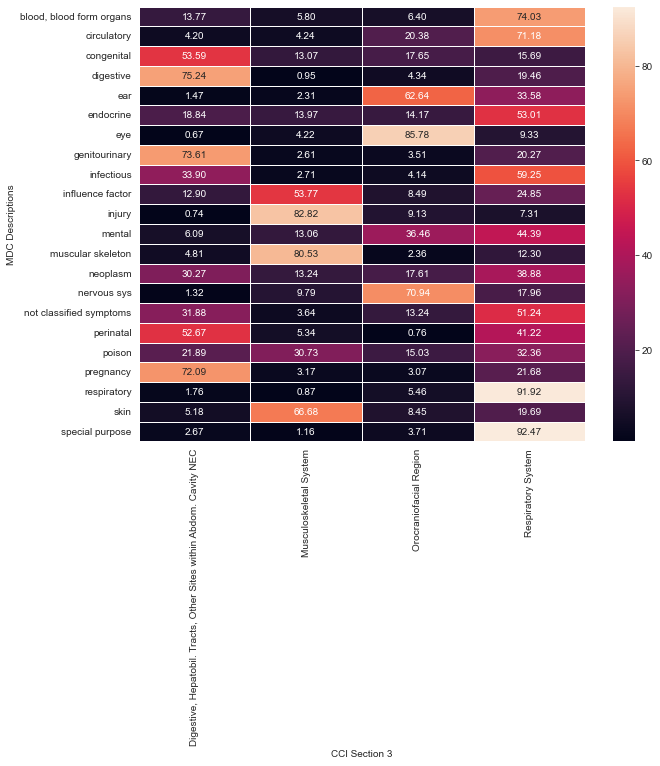

In [50]:
CCI_1_heatmap(dataframe=CCI_1_Section3_top4, section= '3')

Based on the following output above, we can group Section 3 in the following way:
- Ultrasound: head NEC
- Ultrasound: abdominal cavity
- Xray: thoracic cavity NEC
- Xray: abdominal cavity
- CT Scan: abdominal cavity
- D.I. Musculoskeletal
- General D.I. Intervention

Below is the function to identify the particular subgroups of Section 3 codes:

In [51]:
def CCI_Section3(code):
    sectionCode = code[1:3]
    intervention = code[3:5]
    if (sectionCode == 'ER') & (intervention == '20'):
        return "Ultrasound: Head NEC"
    elif (sectionCode == 'GY') & (intervention == '10'):
        return  "Xray: Thoracic Cavity NEC"
    elif (sectionCode >= 'NA') & (sectionCode <= 'OZ'):
        if intervention == '10':
            return "Xray: Abdominal Cavity"
        elif intervention == '20':
            return "CT Scan: Abdominal Cavity"
        elif intervention == '30':
            return "Ultrasound: Abdominal Cavity"
        else:
            return "General D.I. Intervention"
    elif (sectionCode >= 'SC') & (sectionCode <= 'WZ'):
        return "D.I. Musculoskeletal"
    else:
        return "General D.I. Intervention"

## Final Treatment Sections

In [52]:
treatment_df_3 = treatment_df.copy()
def ccisection(code):
    val = code[0]
    if val == '1':
        return CCI_section1(code)
    elif val == '2':
        return CCI_Section2(code)
    elif val == '3':
        return CCI_Section3(code)
    elif val == '5':
        return "Gen. Obstetrical & Fetal Intervention"
    elif val == '6':
        return "Gen. Cognitive, Psych & Sensory Thera. Intervention"
    elif val == '7':
        return "Other Healthcare Intervention"
    elif val == '8':
        return "Strengthening Immune and/or Genetic Composition Intervention"
    else:
        return "No Intervention"

treatment_df_3['CCI_1_SubSection'] = treatment_df_3['PROCCODE1'].apply(ccisection)

#### Plot for CCI Sections Categories

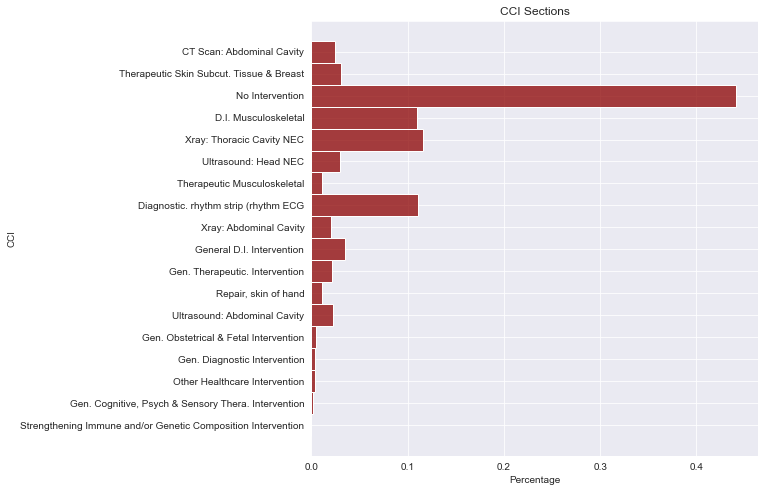

In [53]:
CCI_1_plot(dataframe= treatment_df_3)

In [54]:
CCI_1_table(dataframe= treatment_df_3)

%
No Intervention                                     44.16
Xray: Thoracic Cavity NEC                           11.60
Diagnostic. rhythm strip (rhythm ECG                11.08
D.I. Musculoskeletal                                10.98
General D.I. Intervention                            3.52
Therapeutic Skin Subcut. Tissue & Breast             3.04
Ultrasound: Head NEC                                 3.02
CT Scan: Abdominal Cavity                            2.50
Ultrasound: Abdominal Cavity                         2.20
Gen. Therapeutic. Intervention                       2.19
Xray: Abdominal Cavity                               2.01
Therapeutic Musculoskeletal                          1.14
Repair, skin of hand                                 1.07
Gen. Obstetrical & Fetal Intervention                0.51
Gen. Diagnostic Intervention                         0.40
Other Healthcare Intervention                        0.37
Gen. Cognitive, Psych & Sensory Thera. Interven...   0.20
Strengthening Immune and/or Genetic Composition...   0.01

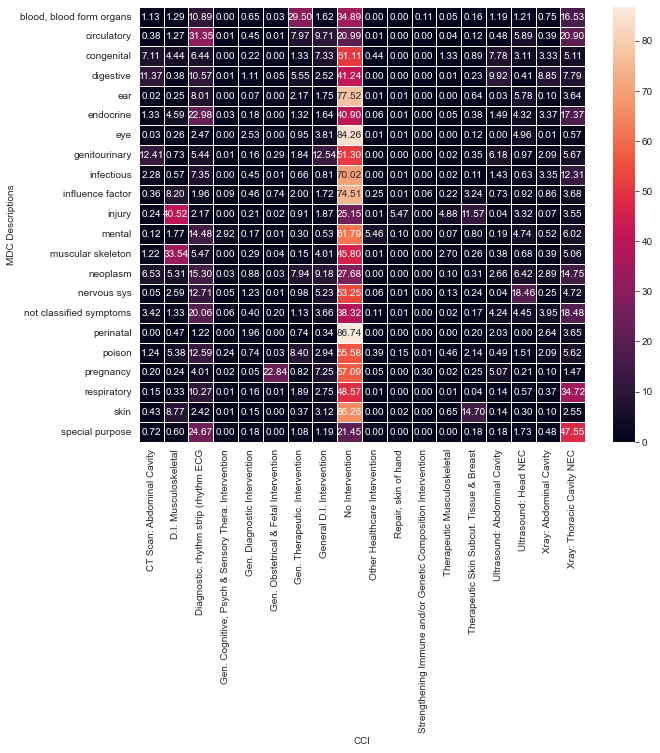

In [55]:
CCI_1_heatmap(dataframe= treatment_df_3)

### Discharged vs. Admitted for Subset Treatment

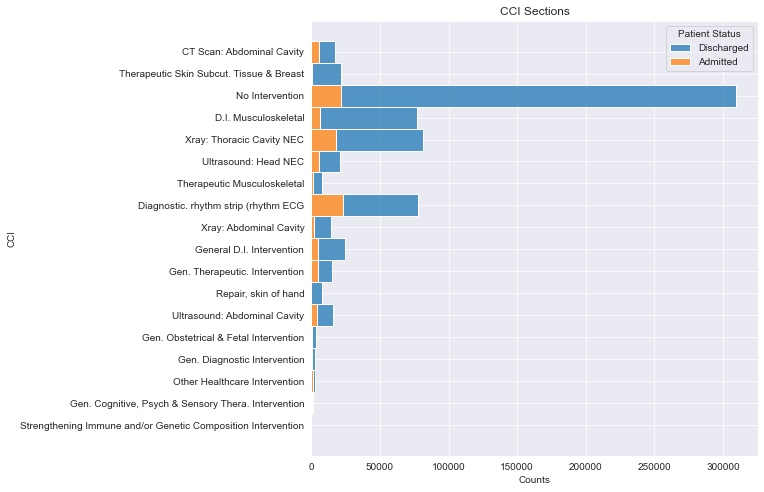

In [56]:
CCI_1_plot(dataframe = treatment_df_3, admitVsDischarge = True)

In [57]:
CCI_1_table(dataframe = treatment_df_3, admitVsDischarge = True)

Discharged %  Admitted %
No Intervention                                            47.98       21.42
D.I. Musculoskeletal                                       11.80        6.13
Xray: Thoracic Cavity NEC                                  10.53       17.93
Diagnostic. rhythm strip (rhythm ECG                        9.11       22.75
Therapeutic Skin Subcut. Tissue & Breast                    3.44        0.65
General D.I. Intervention                                   3.35        4.52
Ultrasound: Head NEC                                        2.59        5.58
CT Scan: Abdominal Cavity                                   2.04        5.22
Xray: Abdominal Cavity                                      1.97        2.24
Ultrasound: Abdominal Cavity                                1.92        3.89
Gen. Therapeutic. Intervention                              1.69        5.17
Repair, skin of hand                                        1.24        0.03
Therapeutic Musculoskeletal                                 1.11        1.34
Gen. Obstetrical & Fetal Intervention                       0.55        0.33
Gen. Diagnostic Intervention                                0.34        0.75
Other Healthcare Intervention                               0.20        1.37
Gen. Cognitive, Psych & Sensory Thera. Interven...          0.12        0.67
Strengthening Immune and/or Genetic Composition...          0.01        0.00

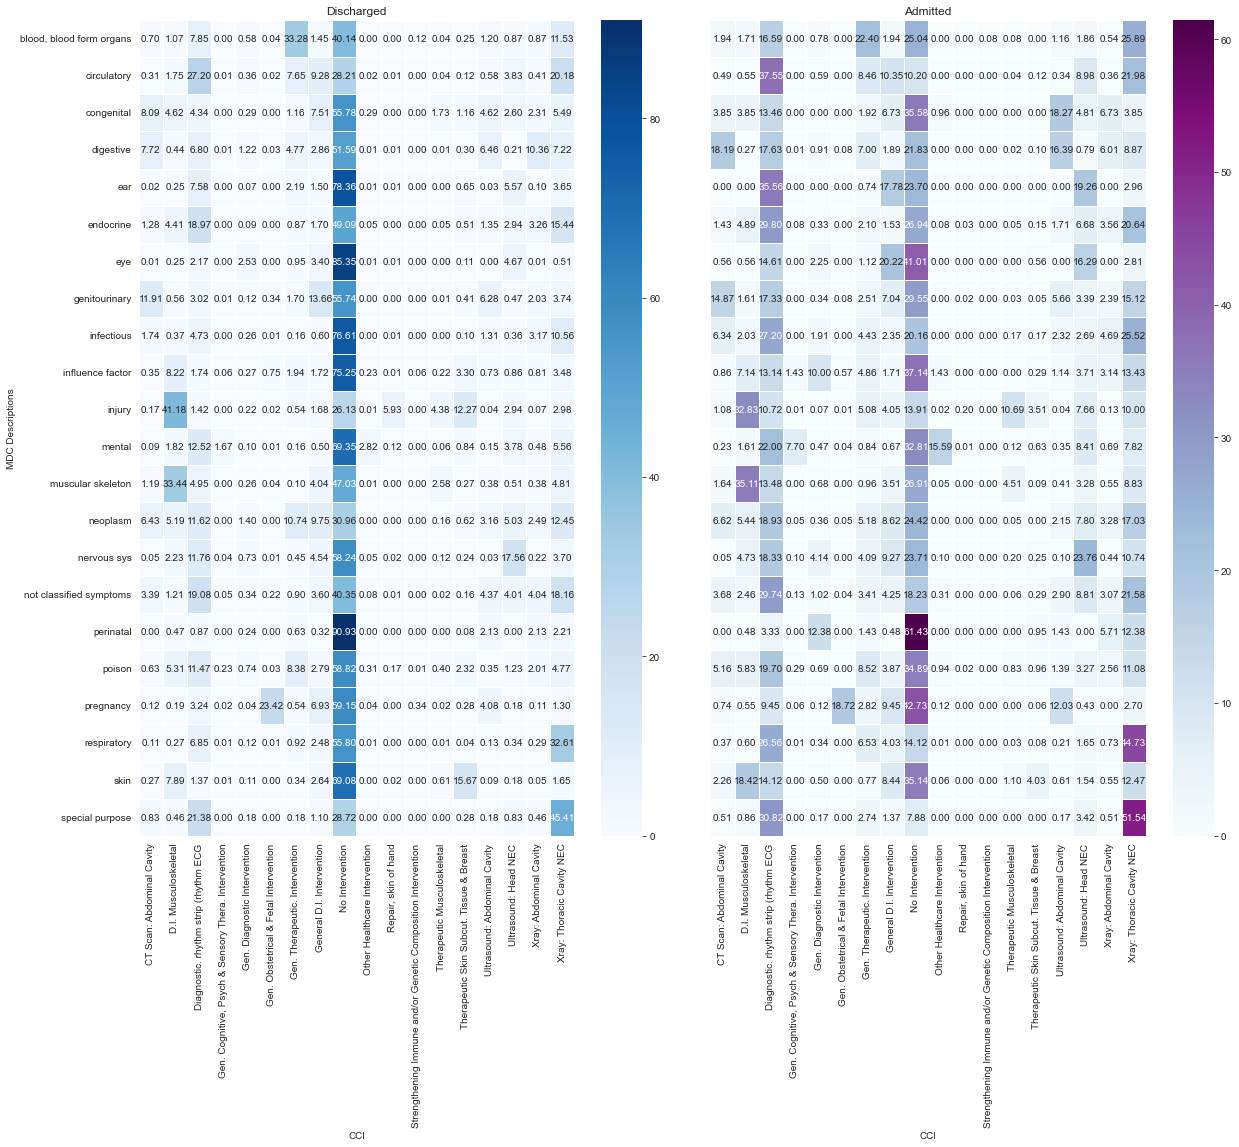

In [58]:
CCI_1_heatmap(dataframe = treatment_df_3, admitVsDischarge = True)

## Age Groups

In [59]:
ageClassification_df = df_rav.copy()

### Counts Within Each Age Group

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, '01-05'),
  Text(1, 0, '06-10'),
  Text(2, 0, '11-15'),
  Text(3, 0, '16-20'),
  Text(4, 0, '21-25'),
  Text(5, 0, '26-30'),
  Text(6, 0, '31-35'),
  Text(7, 0, '36-40'),
  Text(8, 0, '41-45'),
  Text(9, 0, '46-50'),
  Text(10, 0, '51-55'),
  Text(11, 0, '56-60'),
  Text(12, 0, '61-65'),
  Text(13, 0, '66-70'),
  Text(14, 0, '71-75'),
  Text(15, 0, '76-80'),
  Text(16, 0, '81-85'),
  Text(17, 0, '86-90'),
  Text(18, 0, '91-95')])

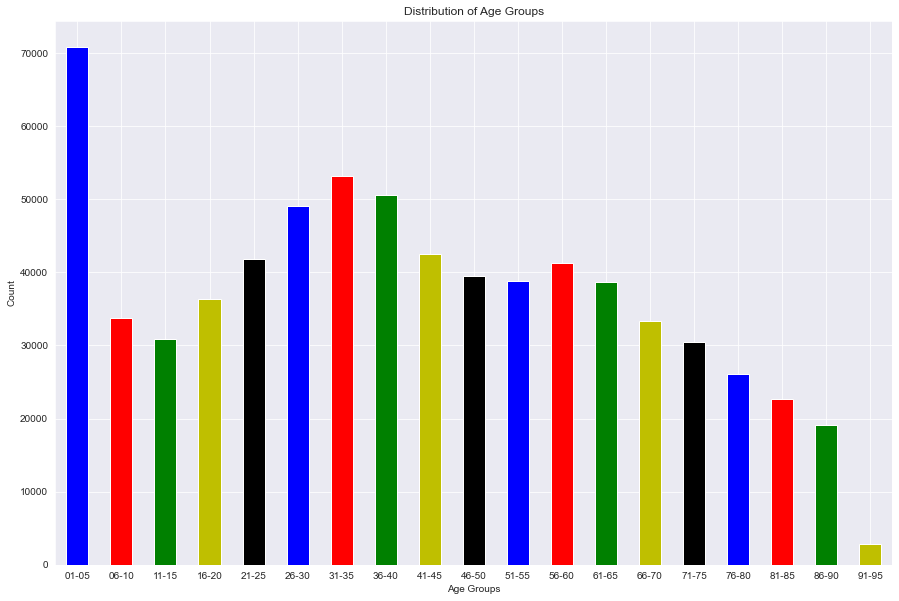

In [60]:
from itertools import cycle, islice
ages = ageClassification_df.groupby(ageClassification_df.age_groups)['PTID'].count()
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(ages)))
plt.figure(figsize=(15,10))
ages.plot(kind = 'bar', color = my_colors)
plt.title('Distribution of Age Groups')
plt.ylabel('Count')
plt.xlabel('Age Groups')
plt.xticks(rotation = 0)

#### Age Groups and Treatment (General and split/grouped treatments)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, '01-05'),
  Text(1, 0, '06-10'),
  Text(2, 0, '11-15'),
  Text(3, 0, '16-20'),
  Text(4, 0, '21-25'),
  Text(5, 0, '26-30'),
  Text(6, 0, '31-35'),
  Text(7, 0, '36-40'),
  Text(8, 0, '41-45'),
  Text(9, 0, '46-50'),
  Text(10, 0, '51-55'),
  Text(11, 0, '56-60'),
  Text(12, 0, '61-65'),
  Text(13, 0, '66-70'),
  Text(14, 0, '71-75'),
  Text(15, 0, '76-80'),
  Text(16, 0, '81-85'),
  Text(17, 0, '86-90'),
  Text(18, 0, '91-95')])

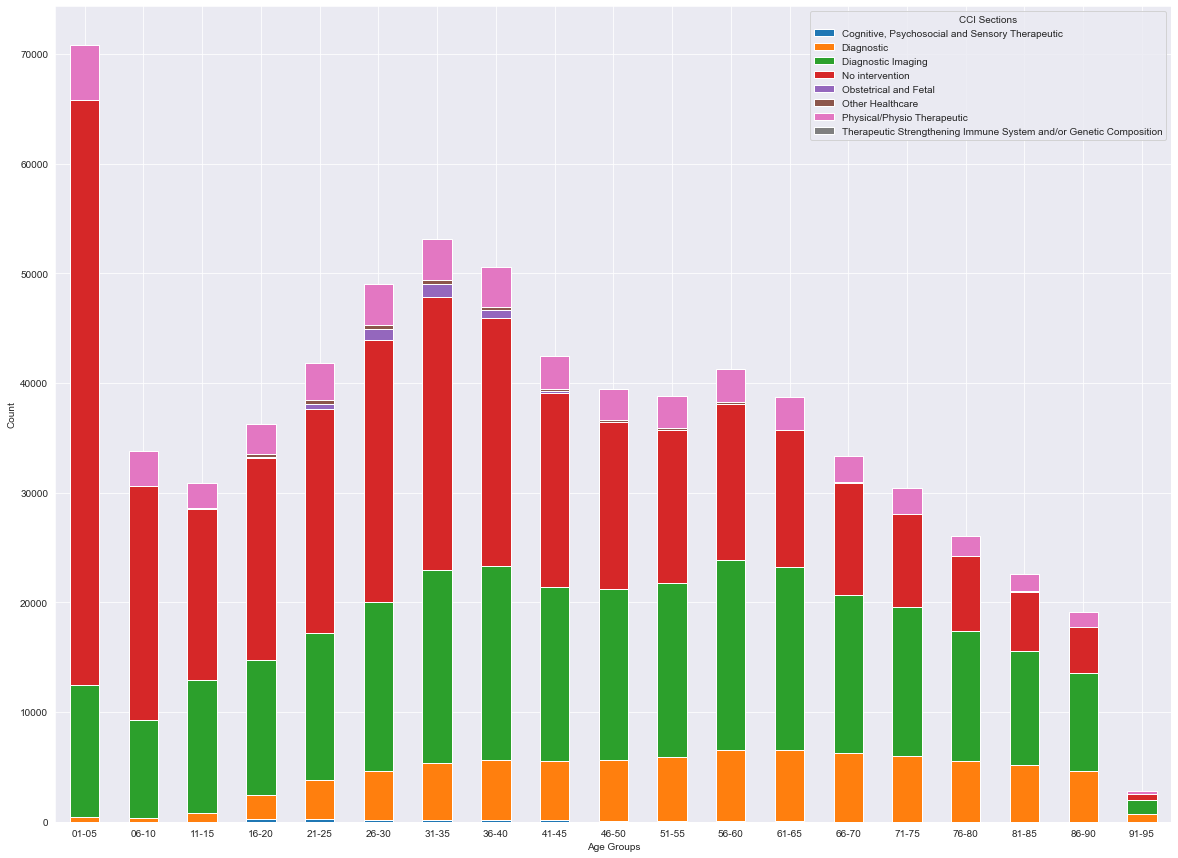

In [61]:
plt.rcParams["figure.figsize"] = (20,15)
agegroupsVsCCI_1_Sections      = ageClassification_df.groupby(['CCI_1_Section', 'age_groups']).size().reset_index().pivot(columns='CCI_1_Section', index = 'age_groups', values = 0)
agegroupsVsCCI_1_Sections.plot(kind = 'bar', stacked = True)
plt.ylabel('Count')
plt.xlabel('Age Groups')
plt.legend(title = 'CCI Sections')
plt.xticks(rotation = 0 )

In [62]:
data         = round((round(agegroupsVsCCI_1_Sections/len(df_rav),4) * 100),2)
data         = data.fillna(0)
data         = data.astype(str) + '%'
cols         = CCI_1_Sections.values()
data         = data[cols]
data.columns = [1,2,3,5,6,7,8,'NoIntervention']
data

1      2      3      5      6      7     8 NoIntervention
age_groups                                                               
01-05       0.72%  0.07%  1.71%   0.0%   0.0%   0.0%  0.0%           7.6%
06-10       0.45%  0.05%  1.27%   0.0%   0.0%   0.0%  0.0%          3.04%
11-15       0.33%  0.11%  1.74%   0.0%   0.0%   0.0%  0.0%          2.22%
16-20       0.39%  0.32%  1.75%  0.01%  0.03%  0.05%  0.0%          2.62%
21-25       0.49%  0.51%  1.91%  0.05%  0.03%  0.05%  0.0%          2.91%
26-30       0.54%  0.63%   2.2%  0.14%  0.03%  0.05%  0.0%          3.41%
31-35       0.54%  0.74%  2.51%  0.17%  0.02%  0.04%  0.0%          3.55%
36-40       0.51%  0.79%  2.52%  0.11%  0.02%  0.04%  0.0%          3.22%
41-45       0.43%  0.77%  2.26%  0.03%  0.02%  0.03%  0.0%          2.52%
46-50        0.4%  0.79%  2.22%   0.0%  0.01%  0.02%  0.0%          2.17%
51-55       0.41%  0.84%  2.27%   0.0%  0.01%  0.02%  0.0%          1.98%
56-60       0.43%  0.92%  2.47%   0.0%  0.01%  0.02%  0.0%          2.03%
61-65       0.42%  0.93%  2.38%   0.0%  0.01%  0.01%  0.0%          1.77%
66-70       0.34%  0.89%  2.05%   0.0%   0.0%  0.01%  0.0%          1.46%
71-75       0.33%  0.85%  1.94%   0.0%   0.0%   0.0%  0.0%          1.21%
76-80       0.25%  0.79%  1.68%   0.0%   0.0%   0.0%  0.0%          0.98%
81-85       0.23%  0.73%  1.49%   0.0%   0.0%   0.0%  0.0%          0.77%
86-90        0.2%  0.65%  1.28%   0.0%   0.0%   0.0%  0.0%           0.6%
91-95       0.03%   0.1%  0.19%   0.0%   0.0%   0.0%  0.0%          0.08%

### Stats Canada Age Classification (Roughly):
- Children (00-15 years old)
- Youth (15-25 years old)
- Adults (25-64)
- Seniors (65+ grouped in 5-year periods)

In [63]:
def statCanAgeGroup(code):
    if code <= '11-15':
        return "Children (00-15)"
    elif (code >= '16-20') & (code <= '21-25'):
        return "Youth (15-24)"
    elif (code >= '26-30') & (code <= '61-65'):
        return "Adults (25-64)"
    else:
        # return f"Seniors ({code})"
        return "Seniors (65+)"
ageClassification_df['StatsCanAgeGrouping'] = ageClassification_df['age_groups'].apply(statCanAgeGroup)

#### Counts Plot for Stats Canada Age Classification

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Children (00-15)'),
  Text(1, 0, 'Youth (15-24)'),
  Text(2, 0, 'Adults (25-64)'),
  Text(3, 0, 'Seniors (65+)')])

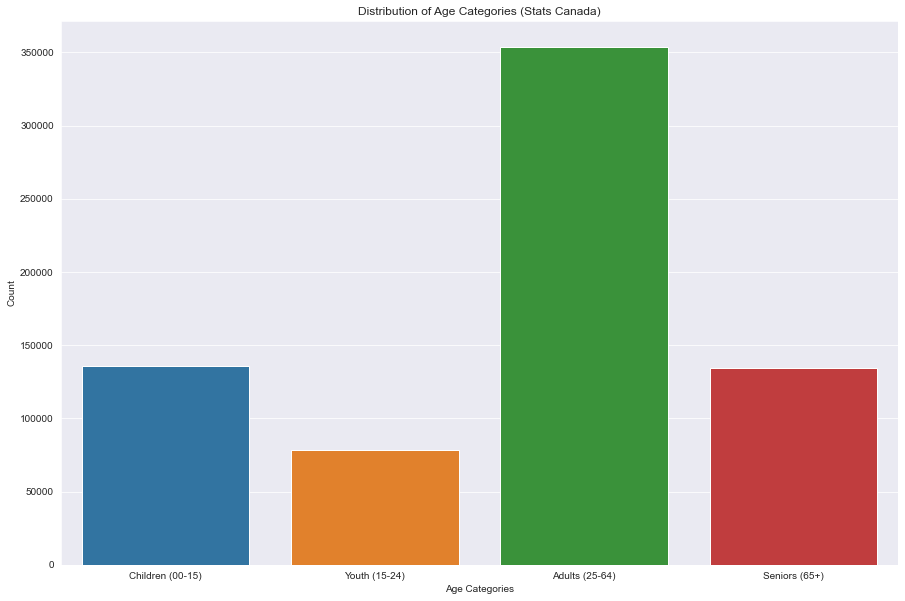

In [64]:
ages            = ageClassification_df.groupby(ageClassification_df.StatsCanAgeGrouping)['PTID'].count()
# Plot
plt.figure(figsize=(15,10))
statsCanGroups1 = ['Children (00-15)', 'Youth (15-24)', 'Adults (25-64)', 'Seniors (66-70)', 'Seniors (71-75)',
                  'Seniors (76-80)', 'Seniors (81-85)', 'Seniors (86-90)', 'Seniors (91-95)']
statsCanGroups2 =  ['Children (00-15)', 'Youth (15-24)', 'Adults (25-64)', 'Seniors (65+)']
sns.countplot(data = ageClassification_df, x = 'StatsCanAgeGrouping', order= statsCanGroups2)
plt.title('Distribution of Age Categories (Stats Canada)')
plt.ylabel('Count')
plt.xlabel('Age Categories')
plt.xticks(rotation = 0)

#### Stat Canada Age Classifications and Treatment (General and split/grouped treatments)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Children (00-15)'),
  Text(1, 0, 'Youth (15-24)'),
  Text(2, 0, 'Adults (25-64)'),
  Text(3, 0, 'Seniors (65+)')])

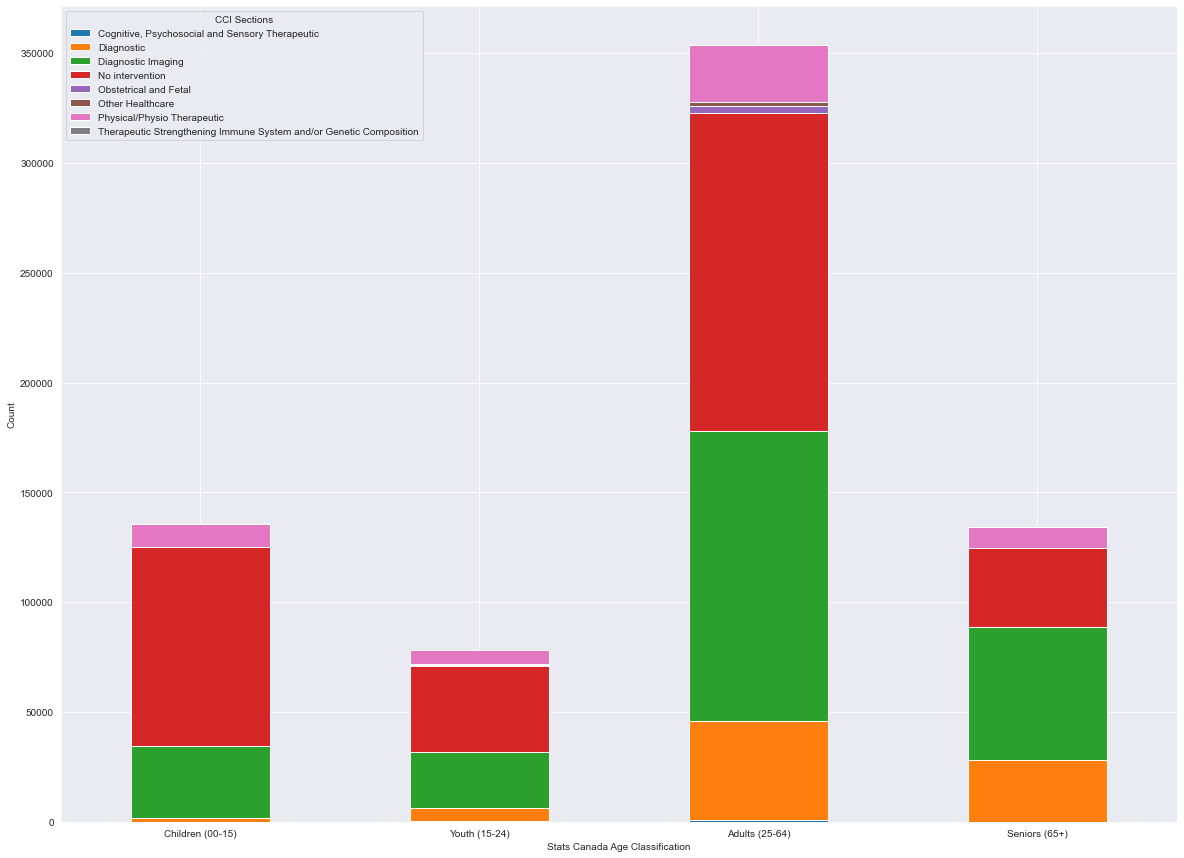

In [65]:
plt.rcParams["figure.figsize"] = (20,15)
agegroupsVsCCI_1_Sections      = ageClassification_df.groupby(['CCI_1_Section', 'StatsCanAgeGrouping']).size().reset_index().pivot(columns='CCI_1_Section', index = 'StatsCanAgeGrouping', values = 0)
agegroupsVsCCI_1_Sections      = agegroupsVsCCI_1_Sections.reindex(statsCanGroups2)
agegroupsVsCCI_1_Sections.plot(kind = 'bar', stacked = True)
plt.ylabel('Count')
plt.xlabel('Stats Canada Age Classification')
plt.legend(title = 'CCI Sections')
plt.xticks(rotation = 0 )

In [66]:
data = round((round(agegroupsVsCCI_1_Sections/len(df_rav),4) * 100),2)
data = data.fillna(0)
data = data.astype(str) + '%'
cols = CCI_1_Sections.values()
data = data[cols]
data.columns = [1,2,3,5,6,7,8,'NoIntervention']
data

1      2       3      5      6      7      8  \
StatsCanAgeGrouping                                                     
Children (00-15)      1.5%  0.22%   4.72%   0.0%   0.0%   0.0%   0.0%   
Youth (15-24)        0.88%  0.83%   3.66%  0.07%  0.06%   0.1%   0.0%   
Adults (25-64)       3.69%  6.41%  18.82%  0.45%  0.12%  0.24%  0.01%   
Seniors (65+)        1.38%  4.02%   8.63%   0.0%  0.01%  0.02%   0.0%   

                    NoIntervention  
StatsCanAgeGrouping                 
Children (00-15)            12.86%  
Youth (15-24)                5.53%  
Adults (25-64)              20.66%  
Seniors (65+)                 5.1%

### Seniors (65+)

#### Heat Map for Seniors (65+) of the treatments vs. diagnostics

Text(0.5, 1.0, 'Seniors 65+')

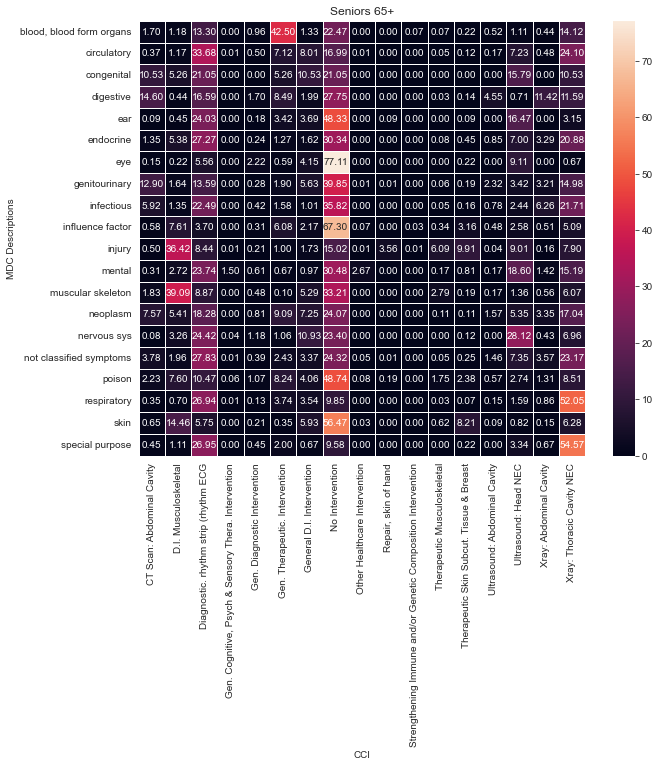

In [67]:
ageClassification_df['CCI_1_SubSection'] = ageClassification_df['PROCCODE1'].apply(ccisection)
seniors = ageClassification_df[ageClassification_df['age_groups'] >= '66-70']
CCI_1_heatmap(dataframe= seniors)
plt.title("Seniors 65+")

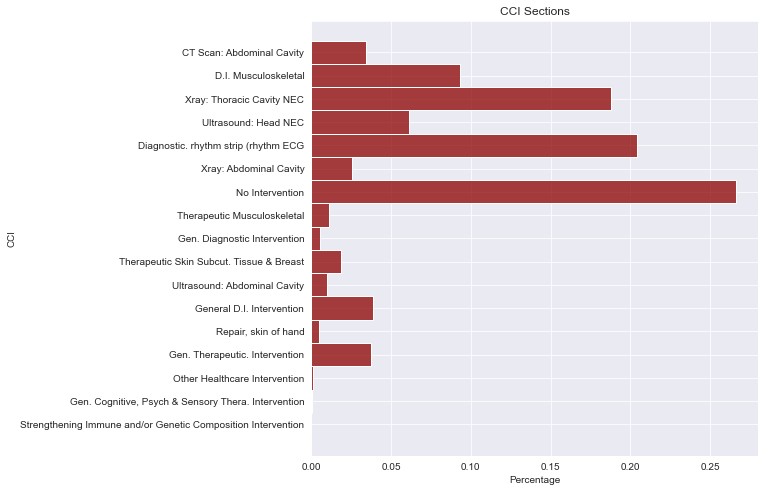

In [68]:
CCI_1_plot(dataframe=seniors)

# Triage Time

## Triage Functions

In [69]:
def triage(data, allTriage = False):
    data                = data[['REGISTRATION_toTriage','INIT_TREAT_LOC_toTriage' ,
                                'PIA_toTriage', 'LAB_toTriage', 'DI_toTriage',
                                'DISPOSITION_toTriage', 'ED_DEPARTURE_toTriage',
                                'DISP_GROUP'
                                ]]
    data                = data.replace({'.': 'Unknown'})
    triageRename        = {"REGISTRATION_toTriage"  : "Registration",
                           "INIT_TREAT_LOC_toTriage": "Enters Treatment Space",
                           "PIA_toTriage"           : "Initial Assessment",
                           "LAB_toTriage"           : "Lab Test",
                           "DI_toTriage"            : "Diagnostic Imaging",
                           "DISPOSITION_toTriage"   : "Disposition",
                           "ED_DEPARTURE_toTriage"  : "Departure"
                           }
    data                = data.rename(columns= triageRename)
    if allTriage is False:
        data            = data[['Initial Assessment', 'Lab Test', 'Diagnostic Imaging', 'Disposition', 'DISP_GROUP']]
        dat             = data.loc[~((data['Initial Assessment']== 'Unknown') |
                                     (data['Lab Test']          == 'Unknown') |
                                     (data['Diagnostic Imaging']== 'Unknown') |
                                     (data['Disposition']       == 'Unknown')
                                     )]
        triageCols      = ['Initial Assessment','Lab Test', 'Diagnostic Imaging', 'Disposition' ]
        dat[triageCols] = dat[triageCols].apply(pd.to_numeric)

    else:
        dat             = data.loc[~(
                (data['Registration']          == 'Unknown') |
                (data['Enters Treatment Space']== 'Unknown') |
                (data['Initial Assessment']    == 'Unknown') |
                (data['Lab Test']              == 'Unknown') |
                (data['Diagnostic Imaging']    == 'Unknown') |
                (data['Disposition']           == 'Unknown') |
                (data['Departure']             == 'Unknown')
        )]
        triageCols      = ["Registration", "Enters Treatment Space",
                           "Initial Assessment", "Lab Test", "Diagnostic Imaging",
                           "Disposition", "Departure"]
    dat[triageCols]     = dat[triageCols].apply(pd.to_numeric)
    data_melt           = pd.melt(dat, value_vars=triageCols, id_vars='DISP_GROUP')
    return data_melt
def triage2(data):
    data                = data[['REGISTRATION_toTriage','INIT_TREAT_LOC_toTriage' ,
                                'PIA_toTriage', 'LAB_toTriage', 'DI_toTriage',
                                'DISPOSITION_toTriage', 'ED_DEPARTURE_toTriage',
                                'DISP_GROUP', 'age_groups', 'GENDER', 'MDC_descrip', 'CCI_1_SubSection'
                                ]]

    demorRename         = {"DISP_GROUP"      : "Patient Status",
                           "age_groups"      : "Age Group",
                           "MDC_descrip"     : "Diagnosis",
                           "CCI_1_SubSection": "Treatment",
                           "GENDER"          : "Gender"
                           }

    triageRename        = {"REGISTRATION_toTriage"  : "Registration",
                           "INIT_TREAT_LOC_toTriage": "Enters Treatment Space",
                           "PIA_toTriage"           : "Initial Assessment",
                           "LAB_toTriage"           : "Lab Test",
                           "DI_toTriage"            : "Diagnostic Imaging",
                           "DISPOSITION_toTriage"   : "Disposition",
                           "ED_DEPARTURE_toTriage"  : "Departure"
                           }
    data                = data.rename(columns = demorRename)
    data                = data.rename(columns = triageRename)
    melt_df             = pd.melt(data, value_vars = triageRename.values(), id_vars = demorRename.values())
    melt_df             = melt_df[melt_df['value'] != 'Unknown']
    melt_df['value']    = melt_df['value'].astype(float)
    return melt_df


## Effects of Treatment on Departure Triage Time

In [70]:
df_rav['CCI_1_SubSection'] = treatment_df_3['PROCCODE1'].apply(ccisection)
triage_df                  = triage2(data = df_rav)

In [71]:
triage_df.variable.unique()

array(['Registration', 'Enters Treatment Space', 'Initial Assessment',
       'Lab Test', 'Diagnostic Imaging', 'Disposition', 'Departure'],
      dtype=object)

Text(0.5, 1.0, 'Female Patients (Age: 75+) Triage to Diagnostic Imaging')

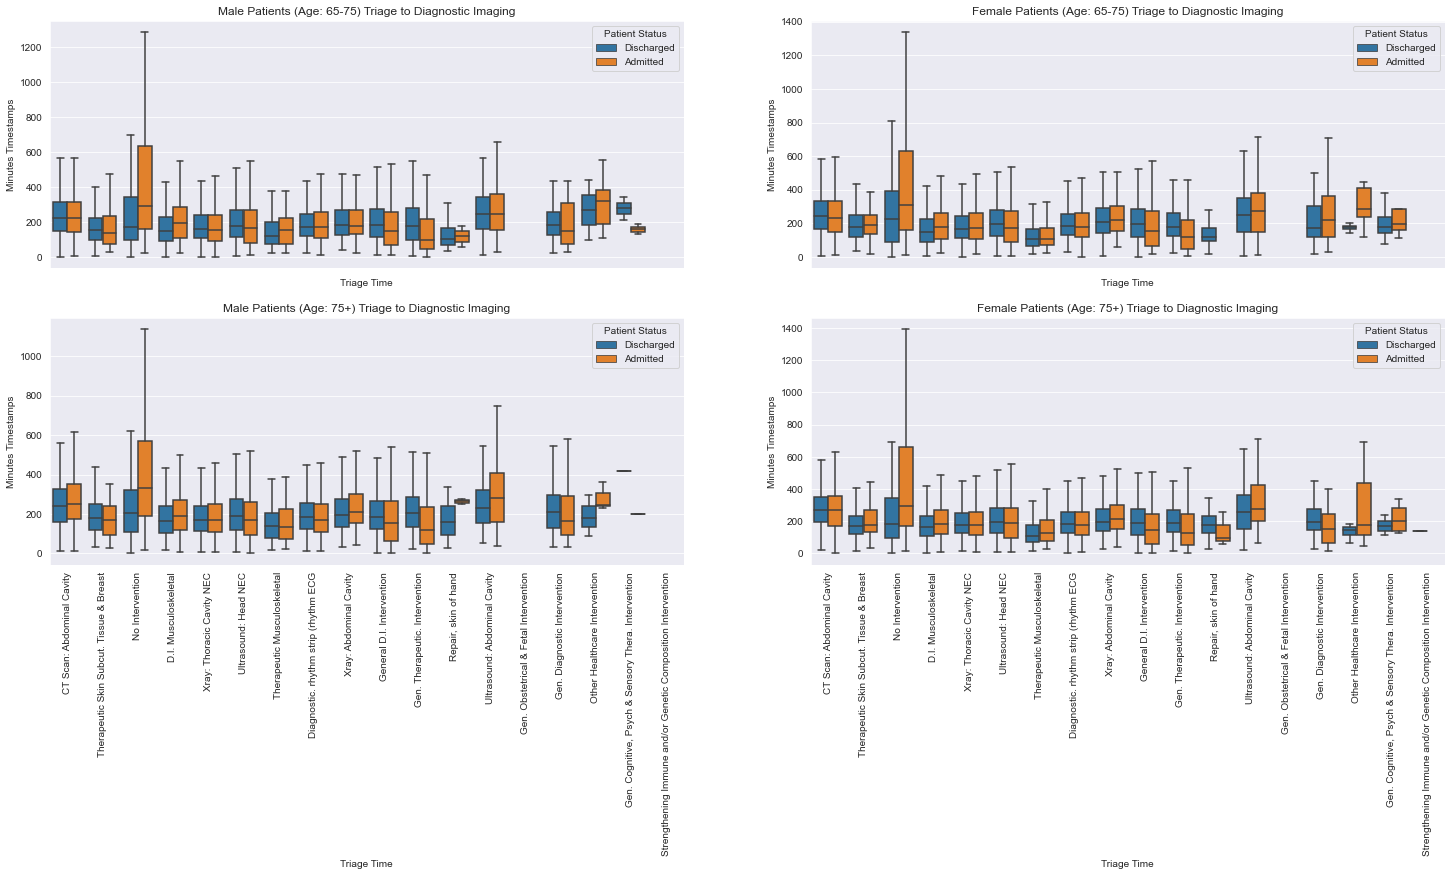

In [72]:
# Male Plot
plt.figure(figsize = (25,10))
plt.subplot(2,2,1)
seniorGroup1_males          = triage_df[
                             ((triage_df['Age Group'] >= '66-70' ) & (triage_df['Age Group'] <='71-75')) &
                              (triage_df['Gender'] == 'M') & (triage_df['variable'] == 'Diagnostic Imaging')
                             ]
ax                          = sns.boxplot(x = 'Treatment', y = 'value', hue = 'Patient Status',
                                          data = seniorGroup1_males, showfliers = False, order = triage_df.Treatment.unique().tolist())
# ax.set(ylim=(0, 1500))
ax.set_xticklabels(labels = "")
ax.set(xlabel = 'Triage Time', ylabel= "Minutes Timestamps")
plt.legend(title = 'Patient Status')
ax.set_title('Male Patients (Age: 65-75) Triage to Diagnostic Imaging')

# Female Plot
plt.subplot(2,2,2)
seniorGroup1_females       = triage_df[
                            ((triage_df['Age Group'] >= '66-70' ) & (triage_df['Age Group'] <='71-75')) &
                             (triage_df['Gender'] == 'F') & (triage_df['variable'] == 'Diagnostic Imaging')
                            ]

ax                         = sns.boxplot(x = 'Treatment', y = 'value', hue = 'Patient Status',
                                         data = seniorGroup1_females, showfliers = False, order = triage_df.Treatment.unique().tolist())
# ax.set(ylim=(0, 1500))
ax.set_xticklabels(labels = "")
ax.set(xlabel = 'Triage Time', ylabel= "Minutes Timestamps")
plt.legend(title = 'Patient Status')
ax.set_title('Female Patients (Age: 65-75) Triage to Diagnostic Imaging')

plt.subplot(2,2,3)
seniorGroup1_males          = triage_df[
    ((triage_df['Age Group'] >= '66-70' ) & (triage_df['Age Group'] >'71-75')) &
    (triage_df['Gender'] == 'M') & (triage_df['variable'] == 'Diagnostic Imaging')
    ]
ax                          = sns.boxplot(x = 'Treatment', y = 'value', hue = 'Patient Status',
                                          data = seniorGroup1_males, showfliers = False, order = triage_df.Treatment.unique().tolist())
# ax.set(ylim=(0, 1500))
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 90)
ax.set(xlabel = 'Triage Time', ylabel= "Minutes Timestamps")
plt.legend(title = 'Patient Status')
ax.set_title('Male Patients (Age: 75+) Triage to Diagnostic Imaging')

# Female Plot
plt.subplot(2,2,4)
seniorGroup1_females       = triage_df[
    ((triage_df['Age Group'] >= '66-70' ) & (triage_df['Age Group'] >'71-75')) &
    (triage_df['Gender'] == 'F') & (triage_df['variable'] == 'Diagnostic Imaging')
    ]

ax                         = sns.boxplot(x = 'Treatment', y = 'value', hue = 'Patient Status',
                                         data = seniorGroup1_females, showfliers = False, order = triage_df.Treatment.unique().tolist())
# ax.set(ylim=(0, 1500))
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 90)
ax.set(xlabel = 'Triage Time', ylabel= "Minutes Timestamps")
plt.legend(title = 'Patient Status')
ax.set_title('Female Patients (Age: 75+) Triage to Diagnostic Imaging')

## Seniors Triage Box plots

### Boxplot of Triage Times for Seniors (65+) With only a few Triage times

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3675528021.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[triageCols]     = dat[triageCols].apply(pd.to_numeric)


Text(0.5, 1.0, 'Senior (65+) Triage Boxplot')

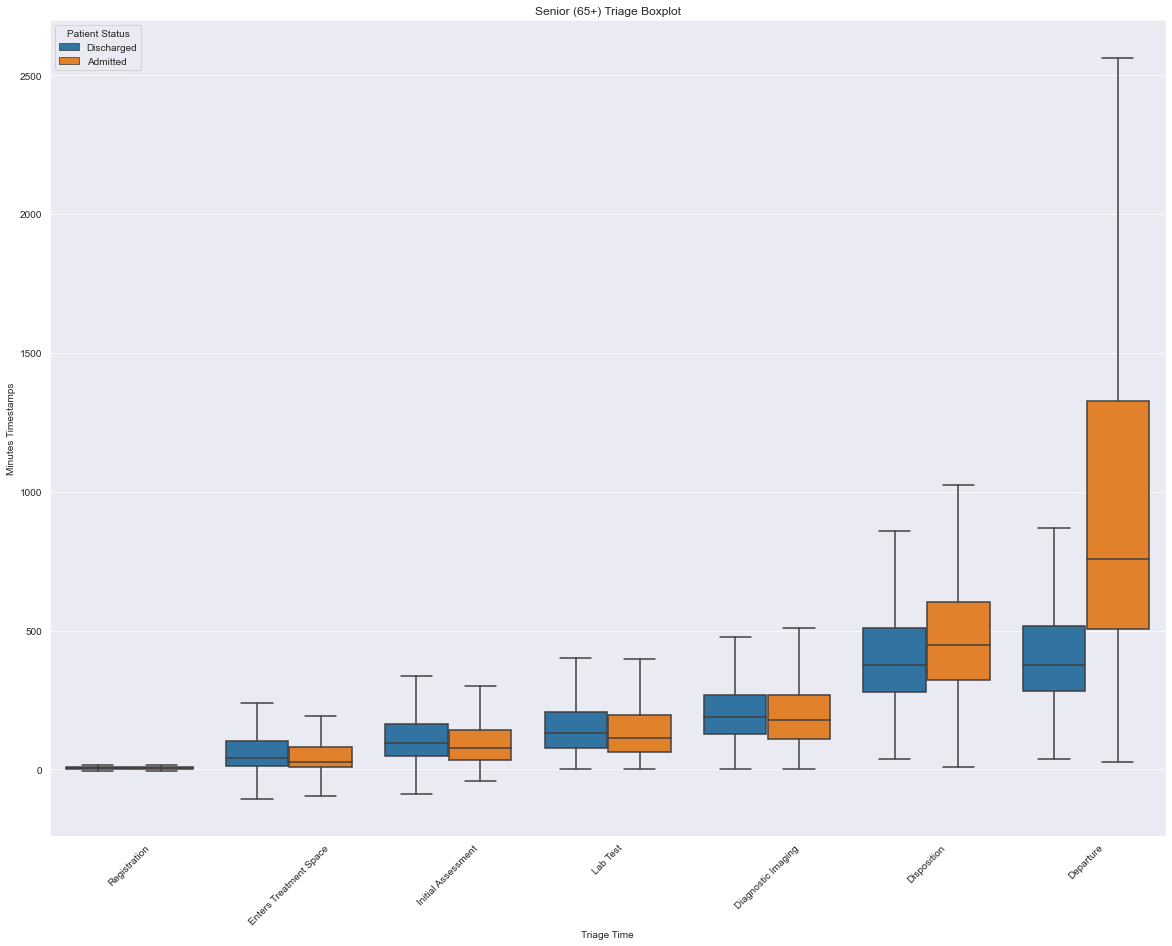

In [73]:
seniors        = df_rav[df_rav['age_groups'] >= '66-70']
seniors_triage = triage(data = seniors, allTriage= True)
ax             = sns.boxplot(x = 'variable', y = 'value', hue = 'DISP_GROUP', data = seniors_triage, showfliers = False)
triageCols  = ["Registration", "Enters Treatment Space","Initial Assessment", "Lab Test", "Diagnostic Imaging", "Disposition", "Departure"]
ax.set_xticklabels(labels = triageCols, rotation = 45)
ax.set(xlabel = 'Triage Time', ylabel= "Minutes Timestamps")
plt.legend(title = 'Patient Status')
plt.title('Senior (65+) Triage Boxplot')

## Sex Adjusted Box plots

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3675528021.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[triageCols]     = dat[triageCols].apply(pd.to_numeric)
/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3675528021.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[triageCols]     = dat[triageCols].apply(pd.to_numeric)


Text(0.5, 1.0, 'Female Triage Box Plot')

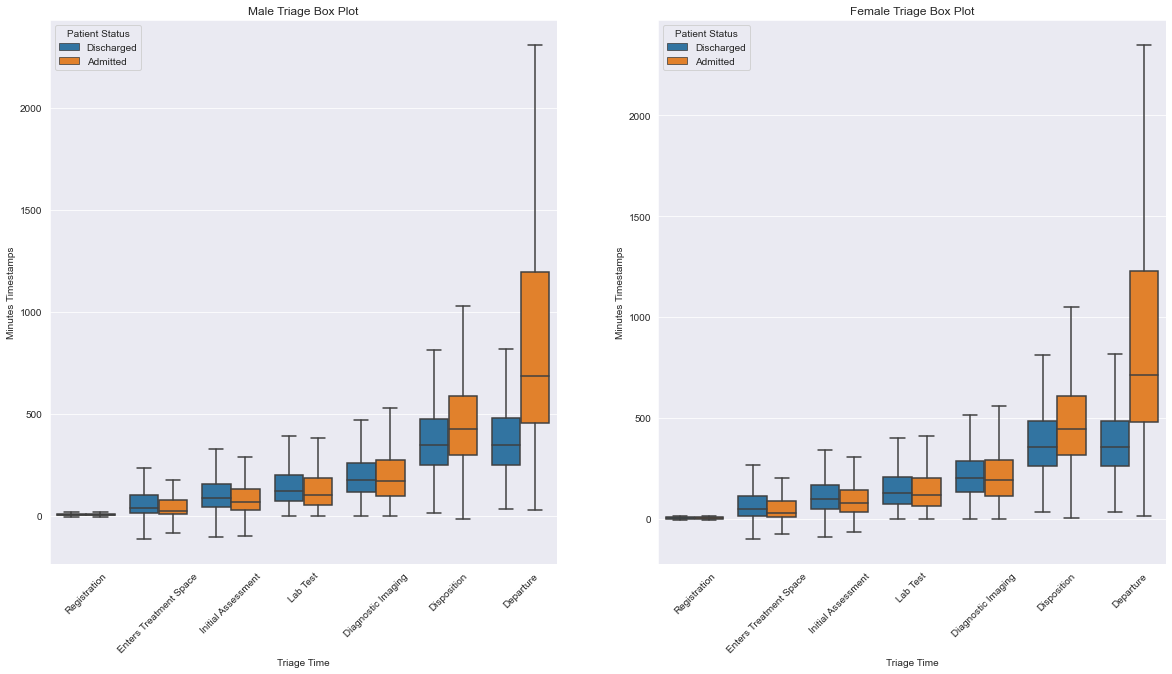

In [74]:
# Male and Female Data Subsetted
males                 = df_rav[df_rav['GENDER'] == 'M']
females               = df_rav[df_rav['GENDER'] == 'F']

# Male Plot
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1)
male_triage = triage(data = males, allTriage= True)
ax          = sns.boxplot(x = 'variable', y = 'value', hue = 'DISP_GROUP', data = male_triage, showfliers = False)
# ax.set(ylim=(0, 1500))
triageCols  = ["Registration", "Enters Treatment Space","Initial Assessment", "Lab Test", "Diagnostic Imaging", "Disposition", "Departure"]
ax.set_xticklabels(labels = triageCols, rotation = 45)
ax.set(xlabel = 'Triage Time', ylabel= "Minutes Timestamps")
plt.legend(title = 'Patient Status')
ax.set_title('Male Triage Box Plot')

# Female Plot
plt.subplot(1,2,2)
female_triage = triage(data = females, allTriage= True)
ax            = sns.boxplot(x = 'variable', y = 'value', hue = 'DISP_GROUP', data = female_triage, showfliers = False)
# ax.set(ylim=(0, 1500))
triageCols    = ["Registration", "Enters Treatment Space","Initial Assessment", "Lab Test", "Diagnostic Imaging", "Disposition", "Departure"]
ax.set_xticklabels(labels = triageCols, rotation = 45)
ax.set(xlabel = 'Triage Time', ylabel= "Minutes Timestamps")
plt.legend(title = 'Patient Status')
ax.set_title('Female Triage Box Plot')

## Senior and Sex Adjust Box Plot

In [75]:
# Data subsetted
seniors             = df_rav[df_rav['age_groups'] >= '66-70']
seniorMale          = seniors[seniors['GENDER'] == 'M']
seniorFemale        = seniors[seniors['GENDER'] == 'F']


seniorMale_triage   = triage(data = seniorMale, allTriage= True)
seniorFemale_triage = triage(data = seniorFemale, allTriage= True)


/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3675528021.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[triageCols]     = dat[triageCols].apply(pd.to_numeric)
/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3675528021.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[triageCols]     = dat[triageCols].apply(pd.to_numeric)


Text(0.5, 1.0, 'Senior (65+) Female Triage Box Plot')

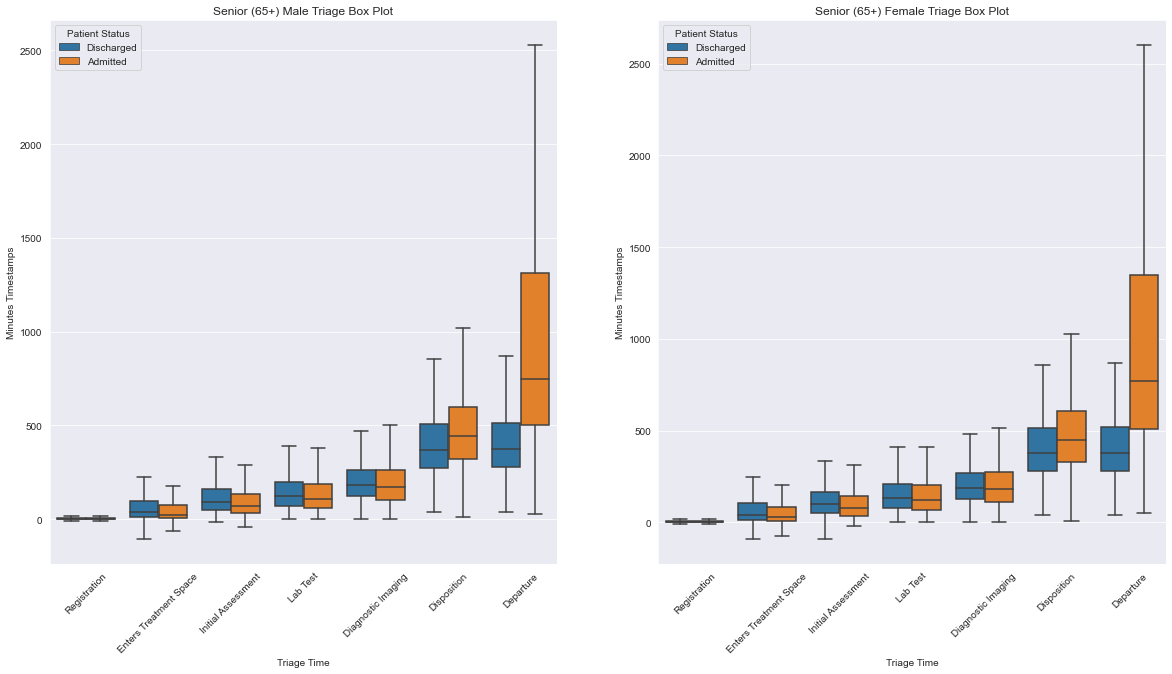

In [76]:
# Male Plot
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1)
ax = sns.boxplot(x = 'variable', y = 'value', hue = 'DISP_GROUP', data = seniorMale_triage, showfliers = False)
# ax.set(ylim=(0, 1500))
ax.set_xticklabels(labels = triageCols, rotation = 45)
ax.set(xlabel = 'Triage Time', ylabel= "Minutes Timestamps")
plt.legend(title = 'Patient Status')
ax.set_title('Senior (65+) Male Triage Box Plot')

# Female Plot
plt.subplot(1,2,2)
ax = sns.boxplot(x = 'variable', y = 'value', hue = 'DISP_GROUP', data = seniorFemale_triage, showfliers = False)
# ax.set(ylim=(0, 1500))
ax.set_xticklabels(labels = triageCols, rotation = 45)
ax.set(xlabel = 'Triage Time', ylabel= "Minutes Timestamps")
plt.legend(title = 'Patient Status')
ax.set_title('Senior (65+) Female Triage Box Plot')

## Looking at Institution Peer Group

### Large Urban

In [77]:
# Peer Group Subsetted
largeUrban        = df_rav[df_rav['INST_PEER_GRP'] == "Large Urban"]
teaching          = df_rav[df_rav['INST_PEER_GRP'] == "Teaching"]
suburb_rural      = df_rav[df_rav['INST_PEER_GRP'] == "Suburban / Rural"]
largeUrban_Ambu   = df_rav[df_rav['INST_PEER_GRP'] == "Large Urban Ambulatory"]

# Triage Filter
largeUrban_triage      = triage(data = largeUrban, allTriage= True)
teaching_triage        = triage(data = teaching, allTriage = True)
suburb_rural_triage    = triage(data = suburb_rural, allTriage= True)
largeUrban_Ambu_triage = triage(data = largeUrban_Ambu, allTriage= True)
peerGroups_triage      = [largeUrban_triage, teaching_triage, suburb_rural_triage,largeUrban_Ambu_triage]

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3675528021.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[triageCols]     = dat[triageCols].apply(pd.to_numeric)
/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3675528021.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[triageCols]     = dat[triageCols].apply(pd.to_numeric)
/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_98463/3675528021.py:40: SettingWithCopyWarning: 
A value is trying to be set 

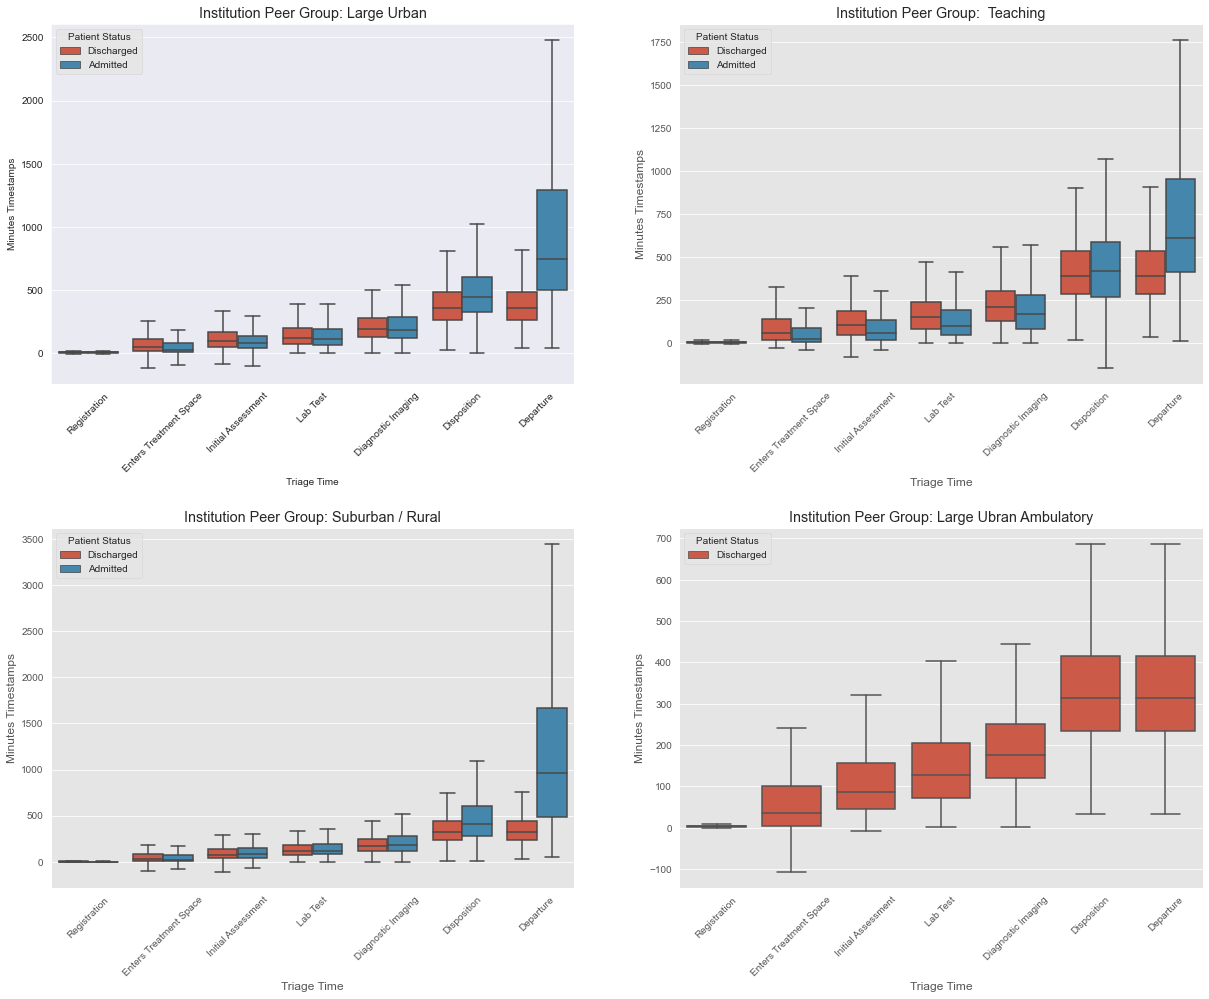

In [78]:
for i, dataset in enumerate(peerGroups_triage):
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
    title = ["Large Urban", " Teaching", "Suburban / Rural", "Large Ubran Ambulatory"]
    plt.subplot(2,2, i+1)
    plt.style.use('ggplot')
    sns.boxplot(x = 'variable', y = 'value', hue = 'DISP_GROUP', data = dataset, showfliers = False)
    plt.xticks(rotation = 45)
    plt.legend(title = 'Patient Status')
    plt.title(f"Institution Peer Group: {title[i]}")
    plt.xlabel("Triage Time")
    plt.ylabel("Minutes Timestamps")

# Logistic Regression

We will only be focusing on 3 predictors which are age group, treatments and sex. Our dependent variable will be the Dispersion status (admitted vs. Discharged).

In [79]:
# Data subsetted
logRegMod                     = df_rav.copy()
logRegMod['CCI_1_SubSection'] = logRegMod['PROCCODE1'].apply(ccisection)
logRegMod                     = logRegMod[['DISP_GROUP', 'CCI_1_SubSection', 'age_groups', 'GENDER', 'MDC_descrip']]
# Renamed the columns
renamed                       = {'DISP_GROUP'      : 'Patient Status',
                                 'CCI_1_SubSection': 'Treatment',
                                 'age_groups'      : 'Age Period',
                                 'GENDER'          : 'Gender',
                                 'MDC_descrip'     : 'Diagnostic'}
logRegMod.rename(columns=renamed, inplace= True)

## Patient Status and Predictors Visualization

<AxesSubplot:xlabel='Patient Status', ylabel='count'>

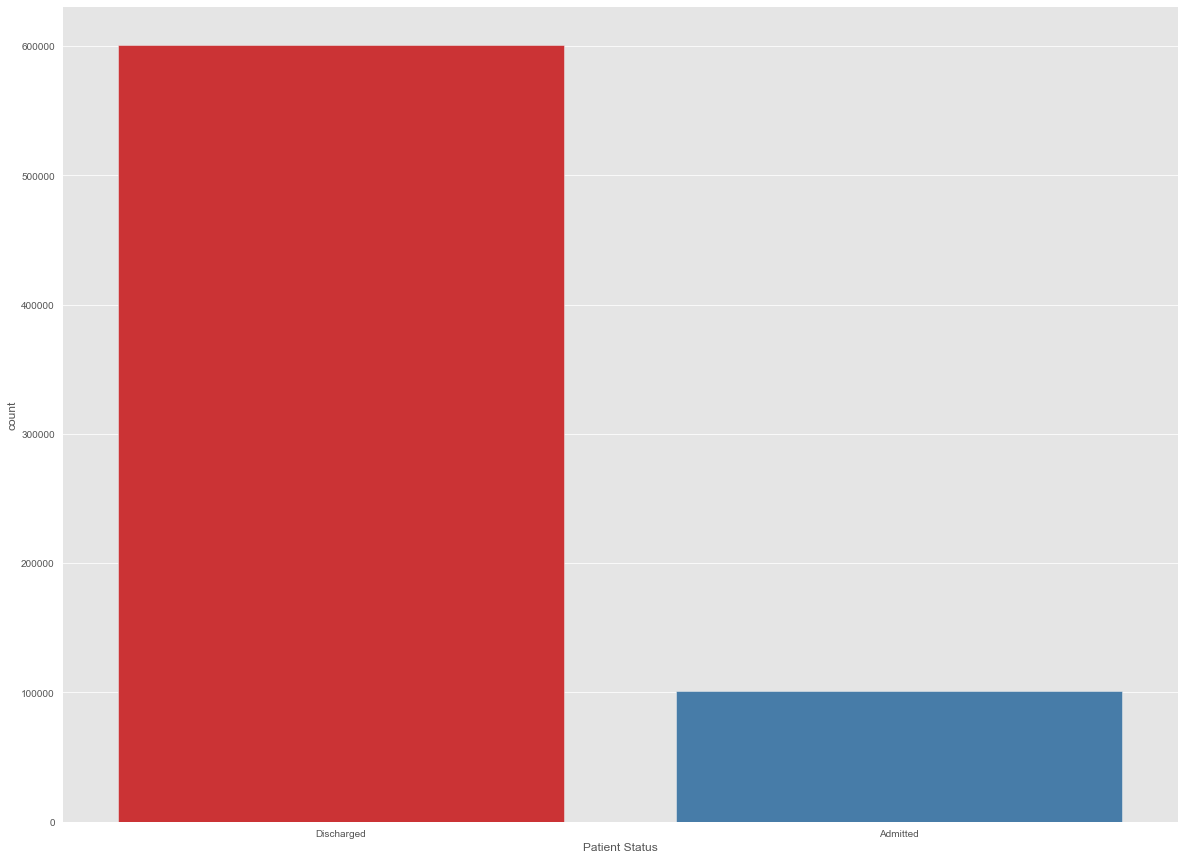

In [80]:
sns.countplot(x = 'Patient Status', data = logRegMod, palette = 'Set1')

<AxesSubplot:xlabel='Patient Status', ylabel='count'>

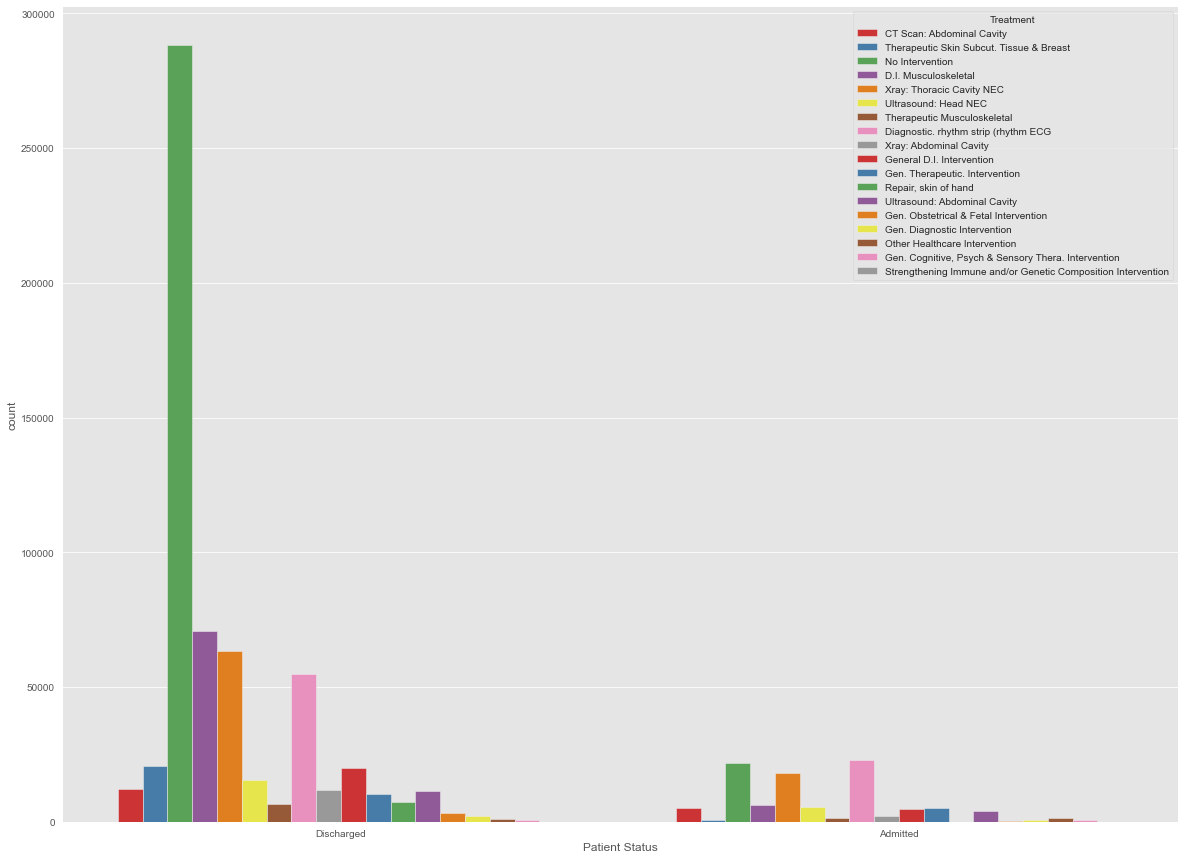

In [81]:
sns.countplot(x = 'Patient Status', hue = 'Treatment', data = logRegMod, palette = 'Set1')

<AxesSubplot:xlabel='Patient Status', ylabel='count'>

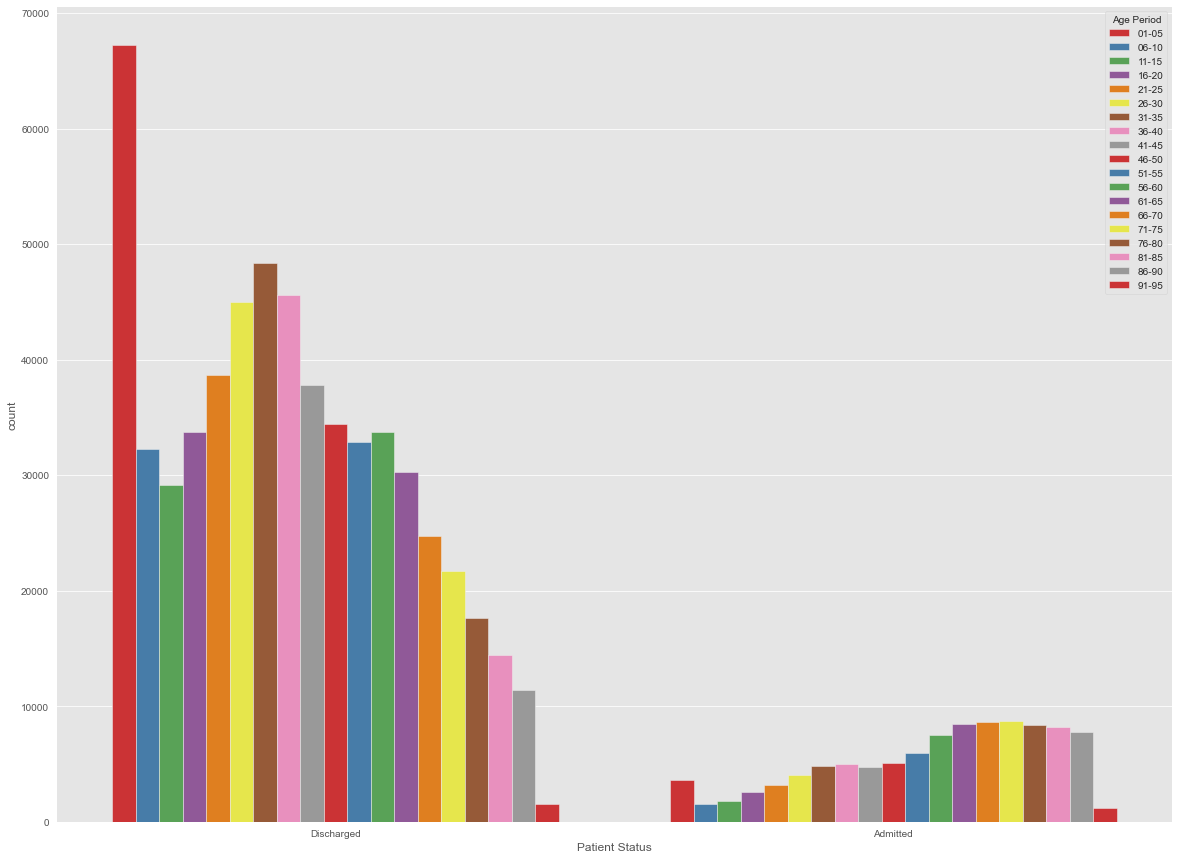

In [82]:
ageOrder           = logRegMod['Age Period'].sort_values().unique()
sns.countplot(data = logRegMod, x = 'Patient Status', hue = 'Age Period',  hue_order = ageOrder, palette = 'Set1')

## Logistic Model: DISP_GROUP ~ Treatments

In [83]:
X = pd.get_dummies(logRegMod[['Treatment']], drop_first= True, prefix_sep= ": ")
Y = pd.get_dummies(logRegMod[['Patient Status']], drop_first= True)
Y.value_counts()/logRegMod.shape[0]

Patient Status_Discharged
1                            0.855978
0                            0.144022
dtype: float64

Unbalanced weights: We need to adjust this when we perform the logistic regression model

### Model Fitting and Results

In [84]:
# Training/Testing Specifications
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state = 0)

# Logistic Model
weights                          = {0: 0.855978, 1: 0.144022}
model                            = LogisticRegression(random_state= 13, class_weight= weights)
model.fit(X_train, Y_train)
predictions_log                  = model.predict(X_test)
print(f'Accuracy Score: {accuracy_score(Y_test,predictions_log)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, predictions_log)}')
print(f'Area Under Curve: {roc_auc_score(Y_test, predictions_log)}')
print(f'Recall score: {recall_score(Y_test,predictions_log)}')

/Users/ravishkamath/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.6595761866299235
Confusion Matrix: 
[[ 21491   8790]
 [ 62859 117330]]
Area Under Curve: 0.6804342959569257
Recall score: 0.6511496262257962


/Users/ravishkamath/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
print(classification_report(Y_test, predictions_log))

              precision    recall  f1-score   support

           0       0.25      0.71      0.37     30281
           1       0.93      0.65      0.77    180189

    accuracy                           0.66    210470
   macro avg       0.59      0.68      0.57    210470
weighted avg       0.83      0.66      0.71    210470



### Feature Importance

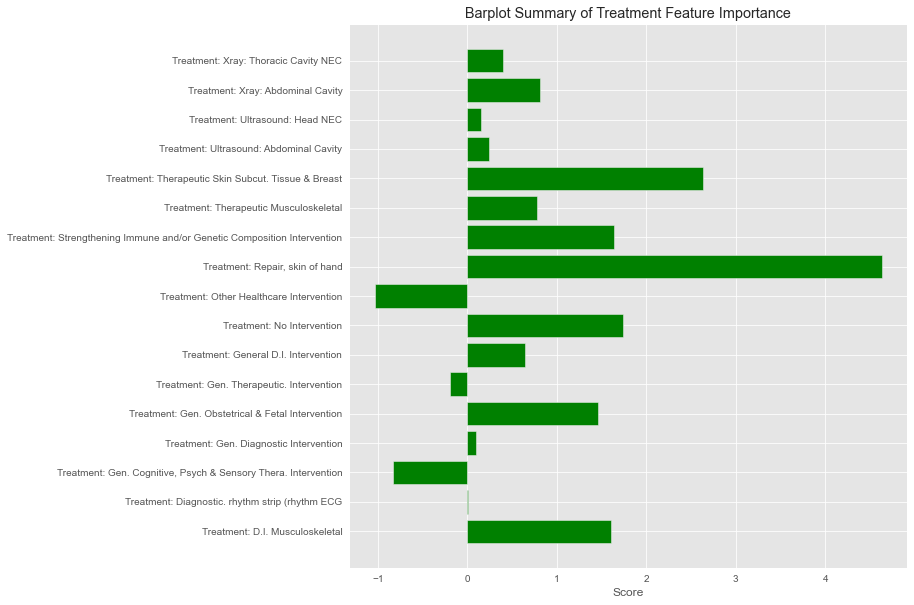

In [86]:
importance = model.coef_.flatten()
plt.rcParams['figure.figsize'] = (10,10)
plt.barh(X.columns, importance, color = 'g')
plt.title("Barplot Summary of Treatment Feature Importance")
plt.xlabel("Score")
plt.show()

### ROC/AUC Curve

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.707


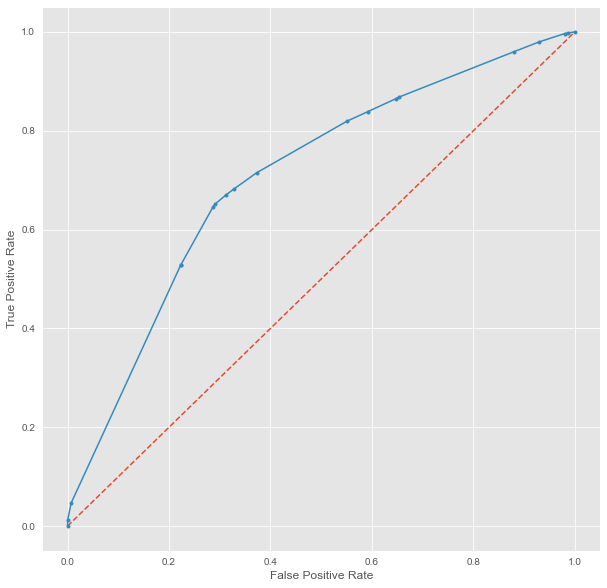

In [87]:
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
# Calculate Scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
#Summarize Scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()

### Precision-Recall Curve

An approach in the related field of information retrieval (finding documents based on queries) measures precision and recall. These measures are also useful in applied machine learning for evaluating binary classification models

- Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It decribes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.
- Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as the sensitivity.

This is quite useeful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1). Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class.

A precision-recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds, much like the ROC curve.

/Users/ravishkamath/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic: f1=0.766 auc=0.933


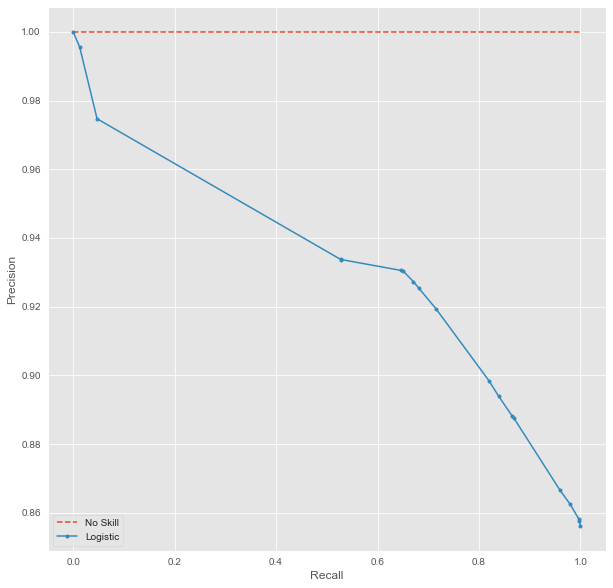

In [88]:
model2 = LogisticRegression(solver='lbfgs')
model2.fit(X_train, Y_train)

# Predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(Y_test, lr_probs)
lr_f1, lr_auc = f1_score(Y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [129]:
departure = triage_df[triage_df['variable'] == 'Departure']
male_depar= departure[(departure['Gender'] == 'M') & (departure['Age Group'] >= '66-70')]
female_depar = departure[(departure['Gender'] == 'F') & (departure['Age Group'] >= '66-70')]

In [128]:
departure['Age Group'].unique()

array(['86-90', '36-40', '21-25', '76-80', '31-35', '41-45', '26-30',
       '51-55', '61-65', '66-70', '56-60', '11-15', '01-05', '71-75',
       '16-20', '06-10', '46-50', '81-85', '91-95'], dtype=object)

(0.0, 2200.0)

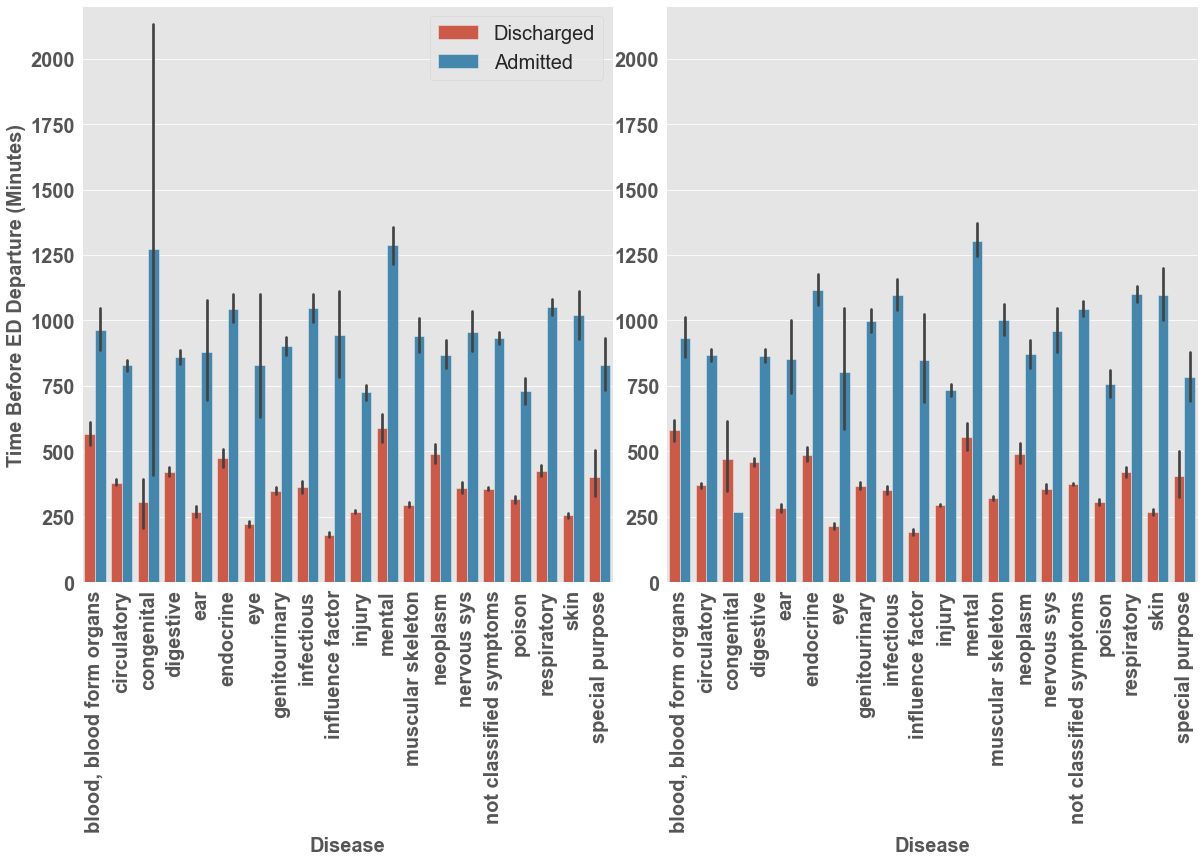

In [184]:
# Male
import matplotlib.gridspec as gridspec
plt.figure(figsize = (20, 10))
plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)
plt.subplot(1,2,1)
ax = sns.barplot(x = "Diagnosis", y = "value", data= male_depar,  order = male_depar.Diagnosis.sort_values().unique() ,  hue="Patient Status")
plt.xticks(rotation = 90, fontsize = 20, weight = 'bold')
plt.yticks(fontsize = 20, weight = 'bold')

plt.legend(title = '', fontsize = 20)
plt.xlabel('Disease',fontsize=20, weight = 'bold')
plt.ylabel("Time Before ED Departure (Minutes)",fontsize=20, weight = 'bold')
plt.ylim([0, 2200])

# Female
plt.subplot(1,2,2)
ax = sns.barplot(x = "Diagnosis", y = "value", data= female_depar, order = male_depar.Diagnosis.sort_values().unique(), hue="Patient Status")
plt.xticks(rotation = 90, fontsize = 20, weight = 'bold')
plt.yticks(fontsize = 20, weight = 'bold')
plt.xlabel('Disease',fontsize=20, weight = 'bold')
plt.ylabel("")
plt.legend(title = 'Patient Status')
ax.get_legend().remove()
plt.ylim([0, 2200])



In [134]:
male_sen = triage_df[(triage_df['Gender'] == 'M') & (triage_df['Age Group'] >= '66-70')]
fem_sen  = triage_df[(triage_df['Gender'] == 'F') & (triage_df['Age Group'] >= '66-70')]

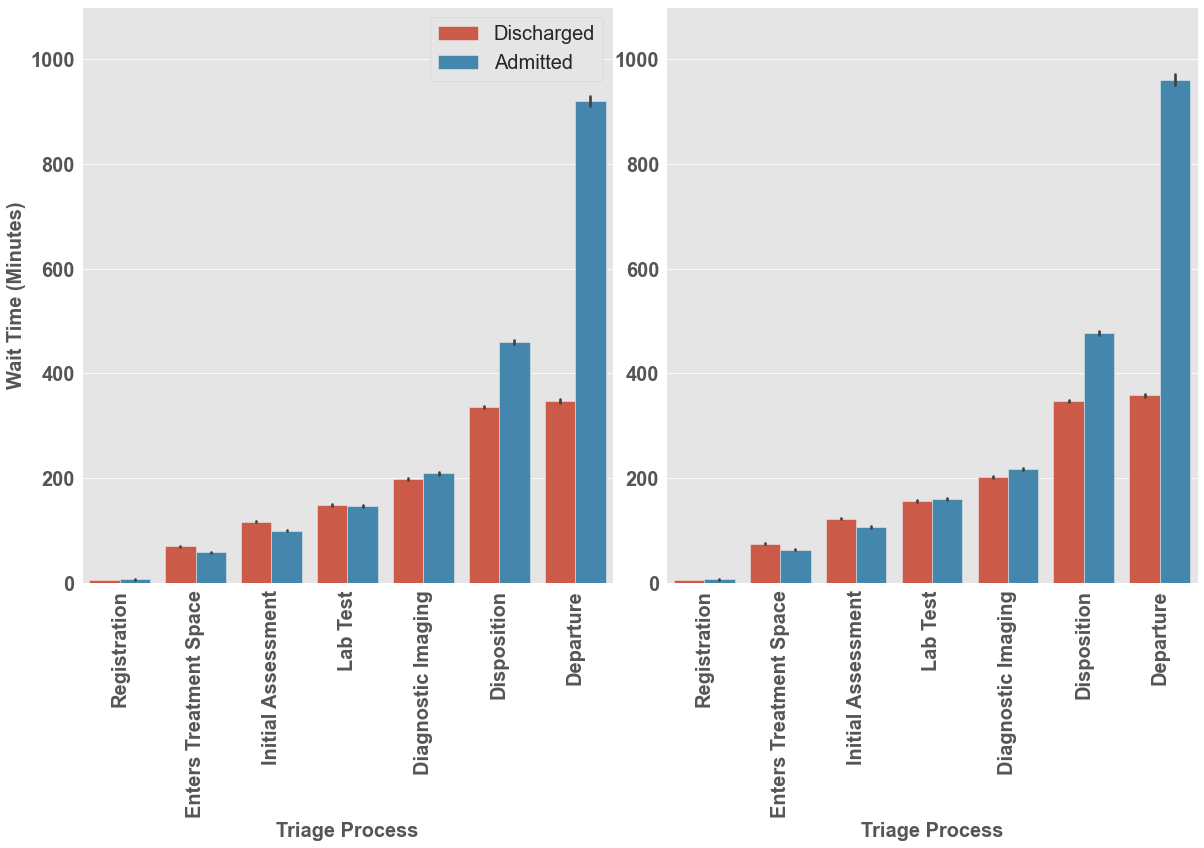

In [188]:
# Male
plt.figure(figsize = (20, 10))
plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)
plt.subplot(1,2,1)
ax = sns.barplot(x = "variable", y = "value", data= male_sen, hue="Patient Status")
plt.xticks(rotation = 90, fontsize = 20, weight = 'bold')
plt.yticks(fontsize = 20, weight = 'bold')
plt.ylim([0,1100])
ax.set(xlabel = 'Triage Process', ylabel= "Wait Time (Minutes)")
plt.ylabel("Wait Time (Minutes)", fontsize = 20, weight = 'bold')
plt.xlabel("Triage Process", fontsize = 20, weight = 'bold')
plt.legend(title = '', fontsize = 20)

# Female
plt.subplot(1,2,2)
ax = sns.barplot(x = "variable", y = "value", data= fem_sen, hue="Patient Status")
plt.xticks(rotation = 90, fontsize = 20, weight = 'bold')
plt.yticks(fontsize = 20, weight = 'bold')
plt.ylabel("")
plt.xlabel("Triage Process", fontsize = 20, weight = 'bold')
plt.ylim([0,1100])
ax.get_legend().remove()
plt.show()